In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt #visualization
import pandas as pd
import seaborn as sns #visualization

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

%matplotlib inline

In [2]:
telcom = pd.read_csv("/Users/olivia/Desktop/Telco Customer Churn/data/datasets_13996_18858_WA_Fn-UseC_-Telco-Customer-Churn.csv")
telcom.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [3]:
print('Telcom dataset has {} rows and {} columns'.format(telcom.shape[0],telcom.shape[1]))

Telcom dataset has 7043 rows and 21 columns


In [4]:
telcom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
for column in telcom.columns:
    uniques = sorted(telcom[column].unique())
    print('{0:20s} {1:5d} \t'.format(column,len(uniques)),uniques[:3]) # ' ' in column TotalCharges

customerID            7043 	 ['0002-ORFBO', '0003-MKNFE', '0004-TLHLJ']
gender                   2 	 ['Female', 'Male']
SeniorCitizen            2 	 [0, 1]
Partner                  2 	 ['No', 'Yes']
Dependents               2 	 ['No', 'Yes']
tenure                  73 	 [0, 1, 2]
PhoneService             2 	 ['No', 'Yes']
MultipleLines            3 	 ['No', 'No phone service', 'Yes']
InternetService          3 	 ['DSL', 'Fiber optic', 'No']
OnlineSecurity           3 	 ['No', 'No internet service', 'Yes']
OnlineBackup             3 	 ['No', 'No internet service', 'Yes']
DeviceProtection         3 	 ['No', 'No internet service', 'Yes']
TechSupport              3 	 ['No', 'No internet service', 'Yes']
StreamingTV              3 	 ['No', 'No internet service', 'Yes']
StreamingMovies          3 	 ['No', 'No internet service', 'Yes']
Contract                 3 	 ['Month-to-month', 'One year', 'Two year']
PaperlessBilling         2 	 ['No', 'Yes']
PaymentMethod            4 	 ['Bank transfer

In [6]:
telcom['TotalCharges'] = telcom['TotalCharges'].replace(" ",np.nan).astype(float)
telcom.describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7032.000000
mean        0.162147    32.371149       64.761692   2283.300441
std         0.368612    24.559481       30.090047   2266.771362
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.500000    401.450000
50%         0.000000    29.000000       70.350000   1397.475000
75%         0.000000    55.000000       89.850000   3794.737500
max         1.000000    72.000000      118.750000   8684.800000

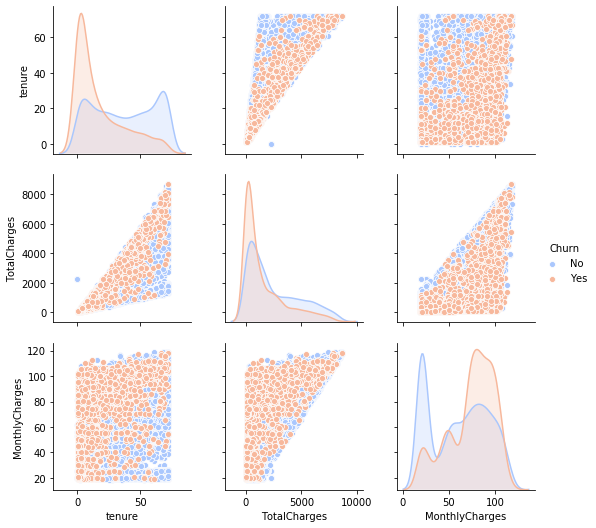

In [7]:
# Replace missing with mean
telcom['TotalCharges'] = telcom['TotalCharges'].replace(np.nan, np.mean(telcom['TotalCharges'][~np.isnan(telcom['TotalCharges'])])) 

# Visualize numeric features
sub = telcom[['tenure','TotalCharges','MonthlyCharges','Churn']]
sns.pairplot(sub, hue='Churn', palette='coolwarm')

In [8]:
target_count = telcom.Churn.value_counts()
print('Churn=1 :', target_count[1])
print('Churn=0 :', target_count[0])
print("'No Churn' to 'Churn' ratio :", round(target_count[0] / target_count[1], 2), ': 1')

Churn=1 : 1869
Churn=0 : 5174
No Churn' to 'Churn' ratio : 2.77 : 1


In [9]:
# Churn {Yes: 1 , No : 0}

telcom.Churn.replace(('Yes', 'No'), (1, 0), inplace=True)

# Under sampling to Churn Yes:No = 1:1

def undersampling(telcom):
    # Class count
    count_class_0, count_class_1 = telcom.Churn.value_counts()

    # Divide by class
    df_class_0 = telcom[telcom['Churn'] == 0]
    df_class_1 = telcom[telcom['Churn'] == 1]
    
    df_class_0_under = df_class_0.sample(count_class_1,replace=False,random_state=33)
    df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

    print('Churn vs No Churn counts after random under-sampling:')
    print(df_test_under.Churn.value_counts())
    
    return df_test_under
    
df_test_under = undersampling(telcom)

Churn vs No Churn counts after random under-sampling:
1    1869
0    1869
Name: Churn, dtype: int64


In [10]:
# Suffling 
telcom_sorted = df_test_under.sample(len(df_test_under),replace=False,random_state=33)
telcom_sorted.reset_index(drop=True, inplace=True)

# One Hot Coding
telcom_oh = pd.get_dummies(telcom_sorted[{'gender',
'SeniorCitizen',
'Partner',
'Dependents',
'PhoneService',
'MultipleLines',
'InternetService',
'OnlineSecurity',
'OnlineBackup',
'DeviceProtection',
'TechSupport',
'StreamingTV',
'StreamingMovies',
'Contract',
'PaperlessBilling',
'PaymentMethod'}])

telcom_full = pd.concat([telcom_oh,telcom_sorted[{'MonthlyCharges','TotalCharges','tenure'}]],axis=1)

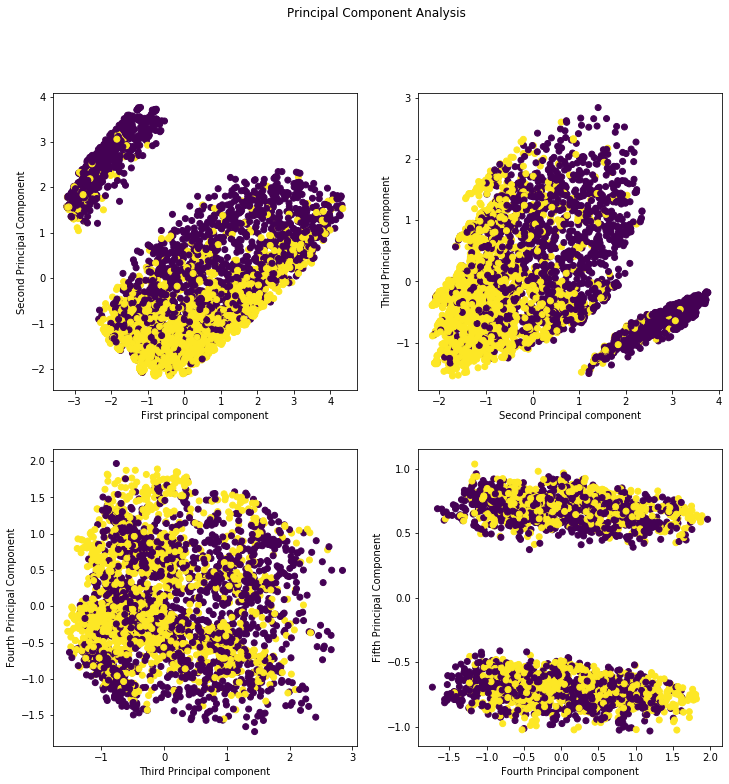

In [11]:
# PCA - visualizate the first 5 dimensions

from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import StandardScaler

telcom_scaled = preprocessing.StandardScaler().fit(telcom_sorted[{'MonthlyCharges','TotalCharges','tenure'}]).transform(telcom_sorted[{'MonthlyCharges','TotalCharges','tenure'}])
telcom_scaled = pd.DataFrame(telcom_scaled, columns = ['MonthlyCharges','TotalCharges','tenure'])
telcom_scaled_full = pd.concat([telcom_oh,telcom_scaled],axis=1)  

pca = PCA(n_components=5)
pca.fit(telcom_scaled_full)
x_pca = pca.transform(telcom_scaled_full)

def pc_visualization(X,label):
    fig, axs = plt.subplots(2, 2,figsize=(12,12))
    axs[0, 0].scatter(X[:,0],X[:,1], c=label)
    axs[0, 0].set_xlabel('First principal component')
    axs[0, 0].set_ylabel('Second Principal Component')
    axs[0, 1].scatter(X[:,1],X[:,2], c=label)
    axs[0, 1].set_xlabel('Second Principal component')
    axs[0, 1].set_ylabel('Third Principal Component')
    axs[1, 0].scatter(X[:,2],X[:,3], c=label)
    axs[1, 0].set_xlabel('Third Principal component')
    axs[1, 0].set_ylabel('Fourth Principal Component')
    axs[1, 1].scatter(X[:,3],X[:,4], c=label)
    axs[1, 1].set_xlabel('Fourth Principal component')
    axs[1, 1].set_ylabel('Fifth Principal Component')
    fig.suptitle('Principal Component Analysis')
    
pc_visualization(x_pca, telcom_sorted['Churn'])

In [12]:
def variace_plot():
    pca = PCA()
    pca.fit(telcom_scaled_full)
    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

    fig = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"},
    )
    fig.show()
    
variace_plot()

In [14]:
# Keep the first 23 principle components, with 100% variance retained.
x_pca = PCA(n_components=23)
pca.fit(telcom_scaled_full)
x_pca = pca.transform(telcom_scaled_full)
x_pca = pd.DataFrame(x_pca)

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
    for colname in col_corr:
        dataset.drop(colname, axis=1, inplace=True)
     
    return print('There are {} features with correlation less than 50%: \n {}'.format(telcom_full.shape[1],telcom_full.columns))

correlation(telcom_full,0.5)

There are 34 features with correlation less than 50%: 
 Index(['SeniorCitizen', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Partner_No', 'Partner_Yes', 'Dependents_No', 'Dependents_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes',
       'StreamingMovies_No', 'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'PaperlessBilling_No', 'PaperlessBilling_Yes', 'gender_Female',
       'gender_Male', 'OnlineBackup_No', 'OnlineBackup_Yes',
       'PhoneService_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'TotalCharges'],
      dtype='object')


In [15]:
from sklearn.model_selection import train_test_split

# Use the first 23 principle components 
X_train_pc23, X_test_pc23, Y_train, Y_test = train_test_split(x_pca, pd.DataFrame(telcom_sorted['Churn']), test_size=0.1, random_state=3)

# Alternatively, use features where in between correlation < 50 % 
# X_train, X_test, Y_train, Y_test = train_test_split(telcom_full, pd.DataFrame(telcom_sorted['Churn']), test_size=0.1, random_state=3)

In [16]:
# KNN Classifier

from sklearn.neighbors import KNeighborsClassifier

def KNeighbors_Classifier(X, Y_train):
    np.random.seed(999)
    knn_2 = KNeighborsClassifier()
    params = dict(n_neighbors=range(1, 50), leaf_size=[1,25,50,100], p=[1,2], algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'])
    #Use GridSearch
    gs_KNN = GridSearchCV(knn_2, params, verbose=2, cv=5)
    #Fit the model
    gs_KNN = gs_KNN.fit(X,Y_train)
    return gs_KNN

gs_KNN = KNeighbors_Classifier(X_train_pc23,Y_train)

Fitting 5 folds for each of 1568 candidates, totalling 7840 fits
[CV] algorithm=auto, leaf_size=1, n_neighbors=1, p=1 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=1, p=1 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=1, p=1 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=1, p=1 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=1, p=1 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .. algorithm=auto, leaf_size=1, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=1, p=2 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=1, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=1, p=2 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=1, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=1, p=2 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=1, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=1, p=2 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=1, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=1, p=2 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=1, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=2, p=1 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=2, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=2, p=1 .................
[CV] .

[CV] .. algorithm=auto, leaf_size=1, n_neighbors=7, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=7, p=1 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=7, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=7, p=1 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=7, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=7, p=2 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=7, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=7, p=2 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=7, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=7, p=2 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=7, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=7, p=2 .................
[CV] .. algorithm=auto, leaf_size=1, n_neighbors=7, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=7, p=2 .................
[CV] .

[CV] . algorithm=auto, leaf_size=1, n_neighbors=13, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=13, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=13, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=13, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=13, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=13, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=13, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=13, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=13, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=13, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=13, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=13, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=13, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=13, p=2 ................
[CV] .

[CV] . algorithm=auto, leaf_size=1, n_neighbors=18, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=19, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=19, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=19, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=19, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=19, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=19, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=19, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=19, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=19, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=19, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=19, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=19, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=1, n_neighbors=19, p=2 ................
[CV] .

[CV] . algorithm=auto, leaf_size=1, n_neighbors=24, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=25, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=25, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=25, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=25, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=25, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=25, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=25, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=25, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=25, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=25, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=25, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=25, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=25, p=2 ................
[CV] .

[CV] . algorithm=auto, leaf_size=1, n_neighbors=30, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=30, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=30, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=30, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=30, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=31, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=31, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=31, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=31, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=31, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=31, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=31, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=31, p=1, total=   0.2s
[CV] algorithm=auto, leaf_size=1, n_neighbors=31, p=1 ................
[CV] .

[CV] . algorithm=auto, leaf_size=1, n_neighbors=36, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=36, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=36, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=36, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=36, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=36, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=36, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=37, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=37, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=37, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=37, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=37, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=37, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=37, p=1 ................
[CV] .

[CV] . algorithm=auto, leaf_size=1, n_neighbors=42, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=42, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=42, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=42, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=42, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=42, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=42, p=2, total=   0.2s
[CV] algorithm=auto, leaf_size=1, n_neighbors=43, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=43, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=43, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=43, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=43, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=43, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=43, p=1 ................
[CV] .

[CV] . algorithm=auto, leaf_size=1, n_neighbors=48, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=48, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=48, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=48, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=48, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=48, p=2 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=49, p=1 ................
[CV] . algorithm=auto, leaf_size=1, n_neighbors=49, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=1, n_neighbors=49, p=1 ................
[CV] .

[CV] . algorithm=auto, leaf_size=25, n_neighbors=5, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=5, p=1 ................
[CV] . algorithm=auto, leaf_size=25, n_neighbors=5, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=5, p=2 ................
[CV] . algorithm=auto, leaf_size=25, n_neighbors=5, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=5, p=2 ................
[CV] . algorithm=auto, leaf_size=25, n_neighbors=5, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=5, p=2 ................
[CV] . algorithm=auto, leaf_size=25, n_neighbors=5, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=5, p=2 ................
[CV] . algorithm=auto, leaf_size=25, n_neighbors=5, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=5, p=2 ................
[CV] . algorithm=auto, leaf_size=25, n_neighbors=5, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=6, p=1 ................
[CV] .

[CV]  algorithm=auto, leaf_size=25, n_neighbors=11, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=11, p=1 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=11, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=11, p=1 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=11, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=11, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=11, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=11, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=11, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=11, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=11, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=11, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=11, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=11, p=2 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=25, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=17, p=1 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=17, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=17, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=17, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=17, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=17, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=17, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=17, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=17, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=17, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=17, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=18, p=1 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=25, n_neighbors=23, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=23, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=23, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=23, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=23, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=23, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=23, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=23, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=23, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=24, p=1 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=24, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=24, p=1 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=24, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=24, p=1 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=25, n_neighbors=29, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=29, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=29, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=29, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=29, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=29, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=29, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=29, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=29, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=30, p=1 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=30, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=30, p=1 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=30, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=30, p=1 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=25, n_neighbors=35, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=35, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=35, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=35, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=35, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=35, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=35, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=35, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=35, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=36, p=1 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=36, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=36, p=1 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=36, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=36, p=1 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=25, n_neighbors=41, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=41, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=41, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=41, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=41, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=41, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=41, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=41, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=41, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=42, p=1 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=42, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=42, p=1 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=42, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=25, n_neighbors=42, p=1 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=25, n_neighbors=47, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=47, p=1 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=47, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=47, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=47, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=47, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=47, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=47, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=47, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=47, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=47, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=47, p=2 ...............
[CV]  algorithm=auto, leaf_size=25, n_neighbors=47, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=25, n_neighbors=48, p=1 ...............
[CV]  

[CV] . algorithm=auto, leaf_size=50, n_neighbors=4, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=4, p=1 ................
[CV] . algorithm=auto, leaf_size=50, n_neighbors=4, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=4, p=1 ................
[CV] . algorithm=auto, leaf_size=50, n_neighbors=4, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=4, p=2 ................
[CV] . algorithm=auto, leaf_size=50, n_neighbors=4, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=4, p=2 ................
[CV] . algorithm=auto, leaf_size=50, n_neighbors=4, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=4, p=2 ................
[CV] . algorithm=auto, leaf_size=50, n_neighbors=4, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=4, p=2 ................
[CV] . algorithm=auto, leaf_size=50, n_neighbors=4, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=4, p=2 ................
[CV] .

[CV]  algorithm=auto, leaf_size=50, n_neighbors=10, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=10, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=10, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=10, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=10, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=10, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=10, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=10, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=10, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=11, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=11, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=11, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=11, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=11, p=1 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=50, n_neighbors=16, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=16, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=16, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=17, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=17, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=17, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=17, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=17, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=17, p=2 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=50, n_neighbors=23, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=23, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=23, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=23, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=23, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=23, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=23, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=23, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=23, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=23, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=23, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=23, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=23, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=23, p=2 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=50, n_neighbors=28, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=29, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=29, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=29, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=29, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=29, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=29, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=29, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=29, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=29, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=29, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=29, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=29, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=29, p=2 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=50, n_neighbors=34, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=35, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=35, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=35, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=35, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=35, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=35, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=35, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=35, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=35, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=35, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=35, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=35, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=35, p=2 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=50, n_neighbors=40, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=50, n_neighbors=40, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=40, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=50, n_neighbors=40, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=40, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=50, n_neighbors=41, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=41, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=50, n_neighbors=41, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=41, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=50, n_neighbors=41, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=41, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=50, n_neighbors=41, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=41, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=41, p=1 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=50, n_neighbors=46, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=46, p=2 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=46, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=47, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=47, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=47, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=47, p=1, total=   0.1s
[CV] algorithm=auto, leaf_size=50, n_neighbors=47, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=47, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=47, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=47, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=47, p=1 ...............
[CV]  algorithm=auto, leaf_size=50, n_neighbors=47, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=50, n_neighbors=47, p=2 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=100, n_neighbors=3, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=4, p=1 ...............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=4, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=4, p=1 ...............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=4, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=4, p=1 ...............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=4, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=4, p=1 ...............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=4, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=4, p=1 ...............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=4, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=4, p=2 ...............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=4, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=4, p=2 ...............
[CV]  

[CV]  algorithm=auto, leaf_size=100, n_neighbors=10, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=10, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=10, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=10, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=10, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=10, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=10, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=10, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=10, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=10, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=10, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=10, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=10, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=10, p=2 ..............

[CV]  algorithm=auto, leaf_size=100, n_neighbors=15, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=100, n_neighbors=15, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=15, p=2, total=   0.1s
[CV] algorithm=auto, leaf_size=100, n_neighbors=16, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=16, p=1, total=   0.2s
[CV] algorithm=auto, leaf_size=100, n_neighbors=16, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=16, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=16, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=16, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=16, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=16, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=16, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=16, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=16, p=2 ..............

[CV]  algorithm=auto, leaf_size=100, n_neighbors=21, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=21, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=21, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=21, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=21, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=21, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=21, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=22, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=22, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=22, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=22, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=22, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=22, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=22, p=1 ..............

[CV]  algorithm=auto, leaf_size=100, n_neighbors=27, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=27, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=27, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=27, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=27, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=27, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=27, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=28, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=28, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=28, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=28, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=28, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=28, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=28, p=1 ..............

[CV]  algorithm=auto, leaf_size=100, n_neighbors=33, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=33, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=33, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=33, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=33, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=33, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=33, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=34, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=34, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=34, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=34, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=34, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=34, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=34, p=1 ..............

[CV]  algorithm=auto, leaf_size=100, n_neighbors=39, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=39, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=39, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=39, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=39, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=39, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=39, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=39, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=39, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=40, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=40, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=40, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=40, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=40, p=1 ..............

[CV]  algorithm=auto, leaf_size=100, n_neighbors=45, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=45, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=45, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=45, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=45, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=45, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=45, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=45, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=45, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=45, p=2 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=45, p=2, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=46, p=1 ..............
[CV]  algorithm=auto, leaf_size=100, n_neighbors=46, p=1, total=   0.0s
[CV] algorithm=auto, leaf_size=100, n_neighbors=46, p=1 ..............

[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=2, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=2, p=2 ............
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=2, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=2, p=2 ............
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=2, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=1 ............
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=1 ............
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=1 ............
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=1 ............
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=3, p=

[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=8, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=8, p=2 ............
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=8, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=8, p=2 ............
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=8, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=8, p=2 ............
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=8, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=8, p=2 ............
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=8, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=9, p=1 ............
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=9, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=9, p=1 ............
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=9, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=9, p=

[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=14, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=14, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=14, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=14, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=14, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=14, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=14, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=14, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=14, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=15, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=15, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=15, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=15, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbor

[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=20, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbor

[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=26, p=2, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbor

[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=32, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbor

[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=38, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbor

[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=1, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=1, n_neighbors=44, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=1, n_neighbor

[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=1, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbo

[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=7, p=2, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbo

[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=12, p=2, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1, total=   0.2s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=2, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=25, n_

[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=18, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=18, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=18, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_

[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=24, p=1, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=24, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=24, p=2, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=24, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=24, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=24, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=24, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=25, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=25, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_

[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=30, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_

[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=1, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=1, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=1, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=36, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_

[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=41, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=42, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=42, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=42, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=42, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=42, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=42, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=42, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=42, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=42, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=42, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=42, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=42, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_

[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=25, n_neighbors=48, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=25, n_

[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1 ...........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=2 ...........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=5, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbo

[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=11, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_

[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=17, p=2, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=50, n_

[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=23, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_

[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=29, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_

[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=35, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_

[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=1, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=1, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=41, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_

[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=46, p=2, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=46, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=46, p=2, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=46, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=46, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=47, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=47, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=47, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=47, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=47, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=47, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=47, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=47, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_

[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=1 ..........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=3, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n

[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=9, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=9, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=9, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=9, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=9, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=9, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=9, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=9, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=9, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=9, p=2 ..........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=9, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=10, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=10, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, 

[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=15, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=15, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=15, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=15, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=15, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=15, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=15, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=15, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=15, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=15, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=15, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=16, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=16, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size

[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=21, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=21, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=21, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=21, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=21, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=21, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=21, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=21, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=21, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=21, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=21, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=22, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=22, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size

[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=27, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=27, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=27, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=27, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=27, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=27, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=27, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=27, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=27, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=27, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=27, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=28, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=28, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size

[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=33, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size

[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=39, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size

[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=1, total=   0.1s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=1 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=1, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=2 .........
[CV]  algorithm=ball_tree, leaf_size=100, n_neighbors=45, p=2, total=   0.0s
[CV] algorithm=ball_tree, leaf_size

[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=1, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=1, p=2 ..............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=1, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=2, p=1 ..............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=2, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=2, p=1 ..............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=2, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=2, p=1 ..............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=2, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=2, p=1 ..............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=2, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=2, p=1 ..............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=2, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=2, p=2 ..............

[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=1 ..............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=1 ..............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=1 ..............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=1 ..............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=2 ..............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=2 ..............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=8, p=2 ..............

[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=13, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=14, p=2 ......

[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=19, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=19, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=19, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=20, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=20, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=20, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=20, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=20, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=20, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=20, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=20, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=20, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=20, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=20, p=2 ......

[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=25, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=25, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=25, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=26, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=26, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=26, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=26, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=26, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=26, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=26, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=26, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=26, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=26, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=26, p=2 ......

[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=31, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=31, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=31, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=31, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=31, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=32, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=32, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=32, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=32, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=32, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=32, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=32, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=32, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=32, p=1 ......

[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=37, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=37, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=37, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=37, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=37, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=38, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=38, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=38, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=38, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=38, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=38, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=38, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=38, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=38, p=1 ......

[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=43, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=43, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=43, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=43, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=43, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=44, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=44, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=44, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=44, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=44, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=44, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=44, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=44, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=44, p=1 ......

[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=49, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=49, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=49, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=1, n_neighbors=49, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=1, n_neighbors=49, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=1, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=1, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=1, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=1, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=1, p=1 ......

[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=6, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=6, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=6, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=6, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=6, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=6, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=6, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=6, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=6, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=6, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=6, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=7, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=7, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=7, p=1 ......

[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=12, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=13, p=

[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=18, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=18, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=18, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=18, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=18, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=18, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=18, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=18, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=18, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=18, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=18, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=19, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=19, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=19, p=

[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=24, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=24, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=24, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=24, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=24, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=24, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=25, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=25, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=25, p=

[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=30, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=30, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=30, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=30, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=30, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=30, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=30, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=30, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=30, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=31, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=31, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=31, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=31, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=31, p=

[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=36, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=36, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=36, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=36, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=36, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=36, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=36, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=36, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=36, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=37, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=37, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=37, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=37, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=37, p=

[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=42, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=42, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=42, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=42, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=42, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=42, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=42, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=42, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=42, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=42, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=42, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=43, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=43, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=43, p=

[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=48, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=48, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=48, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=48, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=48, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=48, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=48, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=

[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=1 .............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=2 .............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=6, p=2 ......

[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=12, p=

[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=18, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=19, p=

[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=24, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=24, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=24, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=24, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=25, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=25, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=25, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=25, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=25, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=25, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=25, p=

[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=30, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=30, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=30, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=30, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=30, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=31, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=31, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=31, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=31, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=31, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=31, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=31, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=31, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=31, p=

[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=36, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=36, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=36, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=36, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=36, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=37, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=37, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=37, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=37, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=37, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=37, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=37, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=37, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=37, p=

[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=42, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=42, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=42, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=42, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=42, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=42, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=42, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=42, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=42, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=43, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=43, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=43, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=43, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=43, p=

[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=48, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=48, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=48, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=48, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=48, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=48, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=49, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=49, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=49, p=

[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=1 ............
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=2 ............
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=5, p=2, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=6, p=

[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=11, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbor

[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=16, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=16, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=16, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=17, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=17, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=17, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=17, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=17, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=17, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=17, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbor

[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=22, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=22, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=22, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=22, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=22, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=22, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=22, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=22, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=22, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=23, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=23, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=23, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=23, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbor

[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=28, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbor

[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=1, total=   0.1s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=34, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbor

[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=40, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbor

[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=1 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=1, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=2 ...........
[CV]  algorithm=kd_tree, leaf_size=100, n_neighbors=46, p=2, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=100, n_neighbor

[CV] . algorithm=brute, leaf_size=1, n_neighbors=3, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=3, p=1 ................
[CV] . algorithm=brute, leaf_size=1, n_neighbors=3, p=1, total=   0.0s
[CV] algorithm=brute, leaf_size=1, n_neighbors=3, p=1 ................
[CV] . algorithm=brute, leaf_size=1, n_neighbors=3, p=1, total=   0.0s
[CV] algorithm=brute, leaf_size=1, n_neighbors=3, p=1 ................
[CV] . algorithm=brute, leaf_size=1, n_neighbors=3, p=1, total=   0.0s
[CV] algorithm=brute, leaf_size=1, n_neighbors=3, p=1 ................
[CV] . algorithm=brute, leaf_size=1, n_neighbors=3, p=1, total=   0.0s
[CV] algorithm=brute, leaf_size=1, n_neighbors=3, p=2 ................
[CV] . algorithm=brute, leaf_size=1, n_neighbors=3, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=3, p=2 ................
[CV] . algorithm=brute, leaf_size=1, n_neighbors=3, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=3, p=2 ................
[CV] .

[CV] . algorithm=brute, leaf_size=1, n_neighbors=8, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=8, p=2 ................
[CV] . algorithm=brute, leaf_size=1, n_neighbors=8, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=9, p=1 ................
[CV] . algorithm=brute, leaf_size=1, n_neighbors=9, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=9, p=1 ................
[CV] . algorithm=brute, leaf_size=1, n_neighbors=9, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=9, p=1 ................
[CV] . algorithm=brute, leaf_size=1, n_neighbors=9, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=9, p=1 ................
[CV] . algorithm=brute, leaf_size=1, n_neighbors=9, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=9, p=1 ................
[CV] . algorithm=brute, leaf_size=1, n_neighbors=9, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=9, p=2 ................
[CV] .

[CV]  algorithm=brute, leaf_size=1, n_neighbors=14, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=14, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=14, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=14, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=14, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=14, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=14, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=15, p=1 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=15, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=15, p=1 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=15, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=15, p=1 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=15, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=15, p=1 ...............
[CV]  

[CV]  algorithm=brute, leaf_size=1, n_neighbors=20, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=20, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=20, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=20, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=20, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=20, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=20, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=20, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=20, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=21, p=1 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=21, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=21, p=1 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=21, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=21, p=1 ...............
[CV]  

[CV]  algorithm=brute, leaf_size=1, n_neighbors=26, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=26, p=1 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=26, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=26, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=26, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=26, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=26, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=26, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=26, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=26, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=26, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=26, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=26, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=27, p=1 ...............
[CV]  

[CV]  algorithm=brute, leaf_size=1, n_neighbors=32, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=32, p=1 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=32, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=32, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=32, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=32, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=32, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=32, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=32, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=32, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=32, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=32, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=32, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=33, p=1 ...............
[CV]  

[CV]  algorithm=brute, leaf_size=1, n_neighbors=38, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=38, p=1 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=38, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=38, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=38, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=38, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=38, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=38, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=38, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=38, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=38, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=38, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=38, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=39, p=1 ...............
[CV]  

[CV]  algorithm=brute, leaf_size=1, n_neighbors=44, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=44, p=1 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=44, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=44, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=44, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=44, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=44, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=44, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=44, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=44, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=44, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=44, p=2 ...............
[CV]  algorithm=brute, leaf_size=1, n_neighbors=44, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=1, n_neighbors=45, p=1 ...............
[CV]  

[CV]  algorithm=brute, leaf_size=25, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=brute, leaf_size=25, n_neighbors=1, p=1 ...............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=brute, leaf_size=25, n_neighbors=1, p=1 ...............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=1, p=1, total=   0.0s
[CV] algorithm=brute, leaf_size=25, n_neighbors=1, p=2 ...............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=1, p=2, total=   0.0s
[CV] algorithm=brute, leaf_size=25, n_neighbors=1, p=2 ...............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=1, p=2, total=   0.0s
[CV] algorithm=brute, leaf_size=25, n_neighbors=1, p=2 ...............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=1, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=1, p=2 ...............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=1, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=1, p=2 ...............
[CV]  

[CV]  algorithm=brute, leaf_size=25, n_neighbors=7, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=7, p=1 ...............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=7, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=7, p=2 ...............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=7, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=7, p=2 ...............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=7, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=7, p=2 ...............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=7, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=7, p=2 ...............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=7, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=7, p=2 ...............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=7, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=8, p=1 ...............
[CV]  

[CV]  algorithm=brute, leaf_size=25, n_neighbors=13, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=13, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=13, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=13, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=13, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=13, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=13, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=13, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=13, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=13, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=13, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=13, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=13, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=14, p=1 ..............

[CV]  algorithm=brute, leaf_size=25, n_neighbors=19, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=19, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=19, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=19, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=19, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=19, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=19, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=19, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=19, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=19, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=19, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=19, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=19, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=19, p=2 ..............

[CV]  algorithm=brute, leaf_size=25, n_neighbors=25, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=25, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=25, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=25, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=25, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=25, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=25, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=25, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=25, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=25, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=25, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=25, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=25, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=25, p=2 ..............

[CV]  algorithm=brute, leaf_size=25, n_neighbors=30, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=31, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=31, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=31, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=31, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=31, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=31, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=31, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=31, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=31, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=31, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=31, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=31, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=31, p=2 ..............

[CV]  algorithm=brute, leaf_size=25, n_neighbors=36, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=36, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=36, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=36, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=36, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=37, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=37, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=37, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=37, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=37, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=37, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=37, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=37, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=37, p=1 ..............

[CV]  algorithm=brute, leaf_size=25, n_neighbors=42, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=42, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=42, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=42, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=42, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=42, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=42, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=43, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=43, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=43, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=43, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=43, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=43, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=43, p=1 ..............

[CV]  algorithm=brute, leaf_size=25, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=48, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=48, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=48, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=48, p=2 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=48, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=49, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=49, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=49, p=1 ..............
[CV]  algorithm=brute, leaf_size=25, n_neighbors=49, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=25, n_neighbors=49, p=1 ..............

[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, p=2 ...............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=6, p=1 ...............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=6, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=6, p=1 ...............
[CV]  

[CV]  algorithm=brute, leaf_size=50, n_neighbors=11, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=11, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=11, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=11, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=11, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=11, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=11, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=11, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=11, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=12, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=12, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=12, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=12, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=12, p=1 ..............

[CV]  algorithm=brute, leaf_size=50, n_neighbors=17, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=17, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=17, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=17, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=17, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=17, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=17, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=17, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=17, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=17, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=17, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=18, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=18, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=18, p=1 ..............

[CV]  algorithm=brute, leaf_size=50, n_neighbors=23, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=23, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=23, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=23, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=23, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=23, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=23, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=23, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=23, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=23, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=23, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=24, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=24, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=24, p=1 ..............

[CV]  algorithm=brute, leaf_size=50, n_neighbors=29, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=29, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=29, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=29, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=29, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=29, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=29, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=29, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=29, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=29, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=29, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=30, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=30, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=30, p=1 ..............

[CV]  algorithm=brute, leaf_size=50, n_neighbors=35, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=35, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=35, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=35, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=35, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=35, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=35, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=35, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=35, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=36, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=36, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=36, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=36, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=36, p=1 ..............

[CV]  algorithm=brute, leaf_size=50, n_neighbors=41, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=41, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=41, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=41, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=41, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=41, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=41, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=42, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=42, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=42, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=42, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=42, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=42, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=42, p=1 ..............

[CV]  algorithm=brute, leaf_size=50, n_neighbors=47, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=47, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=47, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=47, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=47, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=47, p=2 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=47, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=48, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=48, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=48, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=48, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=48, p=1 ..............
[CV]  algorithm=brute, leaf_size=50, n_neighbors=48, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=50, n_neighbors=48, p=1 ..............

[CV]  algorithm=brute, leaf_size=100, n_neighbors=4, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=4, p=2 ..............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=4, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=4, p=2 ..............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=4, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=4, p=2 ..............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=4, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=5, p=1 ..............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=5, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=5, p=1 ..............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=5, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=5, p=1 ..............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=5, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=5, p=1 ..............

[CV]  algorithm=brute, leaf_size=100, n_neighbors=10, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=10, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=10, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=10, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=10, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=11, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=11, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=11, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=11, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=11, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=11, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=11, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=11, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=11, p=1 ......

[CV]  algorithm=brute, leaf_size=100, n_neighbors=16, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=16, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=16, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=16, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=16, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=16, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=16, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=16, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=16, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=16, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=16, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=17, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=17, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=17, p=1 ......

[CV]  algorithm=brute, leaf_size=100, n_neighbors=22, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=22, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=22, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=22, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=22, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=22, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=22, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=22, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=22, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=22, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=22, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=22, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=22, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=22, p=2 ......

[CV]  algorithm=brute, leaf_size=100, n_neighbors=28, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=28, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=28, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=28, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=28, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=28, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=28, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=28, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=28, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=28, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=28, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=28, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=28, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=28, p=2 ......

[CV]  algorithm=brute, leaf_size=100, n_neighbors=33, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=34, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=34, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=34, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=34, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=34, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=34, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=34, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=34, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=34, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=34, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=34, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=34, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=34, p=2 ......

[CV]  algorithm=brute, leaf_size=100, n_neighbors=39, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=40, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=40, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=40, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=40, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=40, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=40, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=40, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=40, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=40, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=40, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=40, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=40, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=40, p=2 ......

[CV]  algorithm=brute, leaf_size=100, n_neighbors=45, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=45, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=45, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=45, p=2 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=45, p=2, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=46, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=46, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=46, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=46, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=46, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=46, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=46, p=1 .............
[CV]  algorithm=brute, leaf_size=100, n_neighbors=46, p=1, total=   0.1s
[CV] algorithm=brute, leaf_size=100, n_neighbors=46, p=1 ......

[Parallel(n_jobs=1)]: Done 7840 out of 7840 | elapsed:  6.5min finished


In [17]:
# Print The value of best Hyperparameters
print('Best K:', gs_KNN.best_estimator_.get_params()['n_neighbors'])
print('Best leaf_size:', gs_KNN.best_estimator_.get_params()['leaf_size'])
print('Best p:', gs_KNN.best_estimator_.get_params()['p'])

Best K: 29
Best leaf_size: 1
Best p: 2


In [18]:
# print classification report 

def performance(model,X_test,Y_test):
    yhat = model.predict(X_test)
    print('Classification report : \n',classification_report(Y_test, yhat))
    print('Confusion matrix : \n',confusion_matrix(Y_test,yhat))
    acc_pct = np.around(((confusion_matrix(Y_test,yhat)[0][0]+confusion_matrix(Y_test,yhat)[1][1])/confusion_matrix(Y_test,yhat).sum())*100 , decimals=2)
    return print('Test accuracy : {}%'.format(acc_pct))

performance(gs_KNN, X_test_pc23 , Y_test) 

Classification report : 
               precision    recall  f1-score   support

           0       0.76      0.75      0.75       377
           1       0.75      0.77      0.76       371

    accuracy                           0.76       748
   macro avg       0.76      0.76      0.76       748
weighted avg       0.76      0.76      0.76       748

Confusion matrix : 
 [[281  96]
 [ 87 284]]
Test accuracy : 75.53%


In [19]:
# GaussianNB classifier 

from sklearn.naive_bayes import GaussianNB 

def GaussianNB_Classifier(X, Y_train):
    np.random.seed(999)
    nb_classifier = GaussianNB()
    params = {'var_smoothing': np.logspace(0,-9, num=100)}
    gs_NB = GridSearchCV(estimator=nb_classifier, 
                     param_grid=params, 
                     cv=5,
                     verbose=2, 
                     refit = True,
                     scoring='accuracy')

    gs_NB = gs_NB.fit(X, Y_train)
    return gs_NB

gs_NB = GaussianNB_Classifier(X_train_pc23, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.0s
[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.0s
[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.0s
[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.0s
[CV] var_smoothing=1.0 ...............................................
[CV] ................................ var_smoothing=1.0, total=   0.0s
[CV] var_smoothing=0.8111308307896871 ................................
[CV] ................. var_smoothing=0.8111308307896871, total=   0.0s
[CV] var_smoothing=0.8111308307896871 ................................
[CV] .........

[CV] ................ var_smoothing=0.08111308307896872, total=   0.0s
[CV] var_smoothing=0.08111308307896872 ...............................
[CV] ................ var_smoothing=0.08111308307896872, total=   0.0s
[CV] var_smoothing=0.08111308307896872 ...............................
[CV] ................ var_smoothing=0.08111308307896872, total=   0.0s
[CV] var_smoothing=0.08111308307896872 ...............................
[CV] ................ var_smoothing=0.08111308307896872, total=   0.0s
[CV] var_smoothing=0.08111308307896872 ...............................
[CV] ................ var_smoothing=0.08111308307896872, total=   0.0s
[CV] var_smoothing=0.0657933224657568 ................................
[CV] ................. var_smoothing=0.0657933224657568, total=   0.0s
[CV] var_smoothing=0.0657933224657568 ................................
[CV] ................. var_smoothing=0.0657933224657568, total=   0.0s
[CV] var_smoothing=0.0657933224657568 ................................
[CV] .

[CV] ............... var_smoothing=0.006579332246575682, total=   0.0s
[CV] var_smoothing=0.006579332246575682 ..............................
[CV] ............... var_smoothing=0.006579332246575682, total=   0.0s
[CV] var_smoothing=0.005336699231206307 ..............................
[CV] ............... var_smoothing=0.005336699231206307, total=   0.0s
[CV] var_smoothing=0.005336699231206307 ..............................
[CV] ............... var_smoothing=0.005336699231206307, total=   0.0s
[CV] var_smoothing=0.005336699231206307 ..............................
[CV] ............... var_smoothing=0.005336699231206307, total=   0.0s
[CV] var_smoothing=0.005336699231206307 ..............................
[CV] ............... var_smoothing=0.005336699231206307, total=   0.0s
[CV] var_smoothing=0.005336699231206307 ..............................
[CV] ............... var_smoothing=0.005336699231206307, total=   0.0s
[CV] var_smoothing=0.004328761281083057 ..............................
[CV] .

[CV] .............. var_smoothing=0.0004328761281083057, total=   0.0s
[CV] var_smoothing=0.0004328761281083057 .............................
[CV] .............. var_smoothing=0.0004328761281083057, total=   0.0s
[CV] var_smoothing=0.0004328761281083057 .............................
[CV] .............. var_smoothing=0.0004328761281083057, total=   0.0s
[CV] var_smoothing=0.0004328761281083057 .............................
[CV] .............. var_smoothing=0.0004328761281083057, total=   0.0s
[CV] var_smoothing=0.0003511191734215131 .............................
[CV] .............. var_smoothing=0.0003511191734215131, total=   0.0s
[CV] var_smoothing=0.0003511191734215131 .............................
[CV] .............. var_smoothing=0.0003511191734215131, total=   0.0s
[CV] var_smoothing=0.0003511191734215131 .............................
[CV] .............. var_smoothing=0.0003511191734215131, total=   0.0s
[CV] var_smoothing=0.0003511191734215131 .............................
[CV] .

[CV] .............. var_smoothing=3.511191734215127e-05, total=   0.0s
[CV] var_smoothing=3.511191734215127e-05 .............................
[CV] .............. var_smoothing=3.511191734215127e-05, total=   0.0s
[CV] var_smoothing=2.848035868435799e-05 .............................
[CV] .............. var_smoothing=2.848035868435799e-05, total=   0.0s
[CV] var_smoothing=2.848035868435799e-05 .............................
[CV] .............. var_smoothing=2.848035868435799e-05, total=   0.0s
[CV] var_smoothing=2.848035868435799e-05 .............................
[CV] .............. var_smoothing=2.848035868435799e-05, total=   0.0s
[CV] var_smoothing=2.848035868435799e-05 .............................
[CV] .............. var_smoothing=2.848035868435799e-05, total=   0.0s
[CV] var_smoothing=2.848035868435799e-05 .............................
[CV] .............. var_smoothing=2.848035868435799e-05, total=   0.0s
[CV] var_smoothing=2.310129700083158e-05 .............................
[CV] .

[CV] .............. var_smoothing=2.310129700083158e-06, total=   0.0s
[CV] var_smoothing=2.310129700083158e-06 .............................
[CV] .............. var_smoothing=2.310129700083158e-06, total=   0.0s
[CV] var_smoothing=1.873817422860383e-06 .............................
[CV] .............. var_smoothing=1.873817422860383e-06, total=   0.0s
[CV] var_smoothing=1.873817422860383e-06 .............................
[CV] .............. var_smoothing=1.873817422860383e-06, total=   0.0s
[CV] var_smoothing=1.873817422860383e-06 .............................
[CV] .............. var_smoothing=1.873817422860383e-06, total=   0.0s
[CV] var_smoothing=1.873817422860383e-06 .............................
[CV] .............. var_smoothing=1.873817422860383e-06, total=   0.0s
[CV] var_smoothing=1.873817422860383e-06 .............................
[CV] .............. var_smoothing=1.873817422860383e-06, total=   0.0s
[CV] var_smoothing=1.519911082952933e-06 .............................
[CV] .

[CV] .............. var_smoothing=1.519911082952933e-07, total=   0.0s
[CV] var_smoothing=1.519911082952933e-07 .............................
[CV] .............. var_smoothing=1.519911082952933e-07, total=   0.0s
[CV] var_smoothing=1.519911082952933e-07 .............................
[CV] .............. var_smoothing=1.519911082952933e-07, total=   0.0s
[CV] var_smoothing=1.519911082952933e-07 .............................
[CV] .............. var_smoothing=1.519911082952933e-07, total=   0.0s
[CV] var_smoothing=1.519911082952933e-07 .............................
[CV] .............. var_smoothing=1.519911082952933e-07, total=   0.0s
[CV] var_smoothing=1.232846739442066e-07 .............................
[CV] .............. var_smoothing=1.232846739442066e-07, total=   0.0s
[CV] var_smoothing=1.232846739442066e-07 .............................
[CV] .............. var_smoothing=1.232846739442066e-07, total=   0.0s
[CV] var_smoothing=1.232846739442066e-07 .............................
[CV] .

[CV] .............................. var_smoothing=1e-08, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .............................. var_smoothing=1e-08, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .............................. var_smoothing=1e-08, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .............................. var_smoothing=1e-08, total=   0.0s
[CV] var_smoothing=8.111308307896856e-09 .............................
[CV] .............. var_smoothing=8.111308307896856e-09, total=   0.0s
[CV] var_smoothing=8.111308307896856e-09 .............................
[CV] .............. var_smoothing=8.111308307896856e-09, total=   0.0s
[CV] var_smoothing=8.111308307896856e-09 .............................
[CV] .............. var_smoothing=8.111308307896856e-09, total=   0.0s
[CV] var_smoothing=8.111308307896856e-09 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.2s finished


Best Var.Smoothing : {'var_smoothing': 0.001}


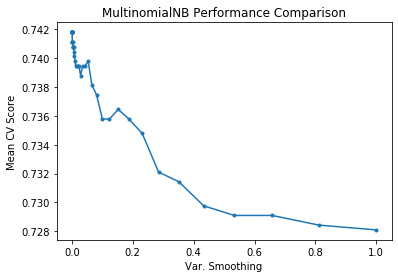

In [20]:
def Smoothing_loss_plot(gs_NB):
    results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
    results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']
    print('Best Var.Smoothing : {}'.format(gs_NB.best_params_))
    plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
    plt.xlabel('Var. Smoothing')
    plt.ylabel("Mean CV Score")
    plt.title("MultinomialNB Performance Comparison")
    plt.show()
    
Smoothing_loss_plot(gs_NB)

In [21]:
print("Best: %f using %s" % (gs_NB.best_score_, gs_NB.best_params_))

Best: 0.741806 using {'var_smoothing': 0.001}


In [22]:
# Print classification report 
performance(gs_NB, X_test_pc23 , Y_test) 

Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.72      0.74       377
           1       0.73      0.78      0.75       371

    accuracy                           0.75       748
   macro avg       0.75      0.75      0.75       748
weighted avg       0.75      0.75      0.75       748

Confusion matrix : 
 [[271 106]
 [ 83 288]]
Test accuracy : 74.73%


In [23]:
# Logistics Regression

from sklearn.linear_model import LogisticRegression

def Logistic_Regression(X, Y_train):
    np.random.seed(999)
    LR_classifier = LogisticRegression()
    params = [{'solver': ['newton-cg', 'lbfgs'], 'penalty':['l2', 'none'], 'C': [10, 1.0, 0.1]},
              {'solver': ['liblinear'], 'penalty':['l2','l1'], 'C': [10, 1.0, 0.1]}]
    gs_LR = GridSearchCV(estimator=LR_classifier, 
                     param_grid=params, 
                     cv=5,
                     verbose=2, 
                     refit = True,
                     scoring='accuracy')
    gs_LR = gs_LR.fit(X, Y_train)
    return gs_LR

gs_LR = Logistic_Regression(X_train_pc23, Y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] C=10, penalty=l2, solver=newton-cg ..............................
[CV] ............... C=10, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, penalty=l2, solver=newton-cg ..............................
[CV] ............... C=10, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, penalty=l2, solver=newton-cg ..............................
[CV] ............... C=10, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, penalty=l2, solver=newton-cg ..............................
[CV] ............... C=10, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, penalty=l2, solver=newton-cg ..............................
[CV] ............... C=10, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ................... C=10, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............. C=10, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, penalty=none, solver=newton-cg ............................
[CV] ............. C=10, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, penalty=none, solver=newton-cg ............................
[CV] ............. C=10, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, penalty=none, solver=newton-cg ............................
[CV] ............. C=10, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, penalty=none, solver=lbfgs ................................
[CV] ................. C=10, penalty=none, solver=lbfgs, total=   0.0s
[CV] C=10, penalty=none, solver=lbfgs ................................
[CV] ................. C=10, penalty=none, solver=lbfgs, total=   0.0s
[CV] C=10, penalty=none, solver=lbfgs ................................
[CV] ................. C=10, penalty=none, solver=lbfgs, total=   0.0s
[CV] C=10, penalty=none, solver=lbfgs ................................
[CV] .

[CV] .............. C=1.0, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=1.0, penalty=l2, solver=liblinear .............................
[CV] .............. C=1.0, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=1.0, penalty=l2, solver=liblinear .............................
[CV] .............. C=1.0, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[CV] .............. C=1.0, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[CV] .............. C=1.0, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[CV] .............. C=1.0, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[CV] .............. C=1.0, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.4s finished


In [24]:
print("Best: %f using %s" % (gs_LR.best_score_, gs_LR.best_params_))

Best: 0.753177 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [25]:
performance(gs_LR, X_test_pc23 , Y_test) 

Classification report : 
               precision    recall  f1-score   support

           0       0.76      0.77      0.77       377
           1       0.76      0.75      0.76       371

    accuracy                           0.76       748
   macro avg       0.76      0.76      0.76       748
weighted avg       0.76      0.76      0.76       748

Confusion matrix : 
 [[290  87]
 [ 91 280]]
Test accuracy : 76.2%


In [26]:
# SVM Classifier

from sklearn import svm
from sklearn.svm import SVC 

def SVM_Classifier(X, Y_train):
    np.random.seed(999)
    # K = 15 
    svm = SVC()
    params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [0.1, 1, 10, 100]},
              {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}]
    #Use GridSearch
    gs_SVM = GridSearchCV(svm, params, verbose=2) 
    #Fit the model
    gs_SVM = gs_SVM.fit(X,Y_train) #Refit an estimator using the best found parameters on the whole train dataset.
    return gs_SVM

gs_SVM = SVM_Classifier(X_train_pc23,Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=   0.2s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=   0.2s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    8.0s finished


In [27]:
print("Best: %f using %s" % (gs_SVM.best_score_, gs_SVM.best_params_))

Best: 0.755184 using {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


In [28]:
# Print classification report 
performance(gs_SVM, X_test_pc23 , Y_test) 

Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.75      0.76       377
           1       0.75      0.77      0.76       371

    accuracy                           0.76       748
   macro avg       0.76      0.76      0.76       748
weighted avg       0.76      0.76      0.76       748

Confusion matrix : 
 [[283  94]
 [ 85 286]]
Test accuracy : 76.07%


In [29]:
# Decision Tree 

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

def DecisionTree(X, Y_train):
    cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)
    df_classifier = DecisionTreeClassifier(random_state=999)
    params = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             "min_samples_split" : [2, 4, 6, 8, 10],
             "max_features": ['auto','log2']
             }
    gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params, 
                     cv=cv_method,
                     verbose=2, 
                     scoring='accuracy',
                     n_jobs=-1)
    gs_DT = gs_DT.fit(X, Y_train)
    return gs_DT

gs_DT = DecisionTree(X_train, Y_train)

Fitting 15 folds for each of 200 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1438 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   19.4s finished


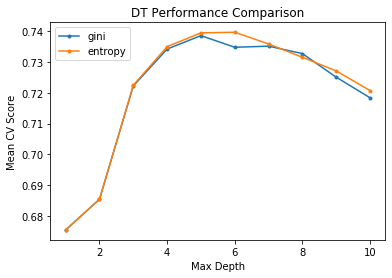

In [30]:
results_DT = pd.DataFrame(gs_DT.cv_results_['params'])
results_DT['test_score'] = gs_DT.cv_results_['mean_test_score']

for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['criterion'] == i]
    temp_average = temp.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

In [31]:
print("Best: %f using %s" % (gs_DT.best_score_, gs_DT.best_params_)) 

Best: 0.741806 using {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 10}


In [32]:
# Print classification report 
performance(gs_DT, X_test, Y_test) 

Classification report : 
               precision    recall  f1-score   support

           0       0.76      0.67      0.71       377
           1       0.70      0.78      0.74       371

    accuracy                           0.73       748
   macro avg       0.73      0.73      0.73       748
weighted avg       0.73      0.73      0.73       748

Confusion matrix : 
 [[254 123]
 [ 82 289]]
Test accuracy : 72.59%


In [33]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

def RandomForest(X, Y_train):
    rf = RandomForestClassifier(oob_score=True, random_state=1, n_jobs=-1)
    param_grid = {'max_features': ['auto','log2'], 
                  "criterion" : ["gini", "entropy"], 
                  'max_depth': [1, 2, 3, 4, 5, 6], 
                  "min_samples_split" : [2, 4, 6, 8, 10], 
                  "n_estimators": [50, 100, 400]}
    gs_RF = GridSearchCV(estimator=rf, param_grid=param_grid, verbose=2, scoring='accuracy', cv=5, n_jobs=-1)
    gs_RF = gs_RF.fit(X, Y_train)
    return gs_RF
gs_RF = RandomForest(X_train, Y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 10.5min finished


In [34]:
print("Best: %f using %s" % (gs_RF.best_score_, gs_RF.best_params_)) 

Best: 0.759532 using {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}


In [35]:
# Print classification report 
performance(gs_RF, X_test, Y_test) 

Classification report : 
               precision    recall  f1-score   support

           0       0.78      0.72      0.75       377
           1       0.74      0.79      0.76       371

    accuracy                           0.76       748
   macro avg       0.76      0.76      0.76       748
weighted avg       0.76      0.76      0.76       748

Confusion matrix : 
 [[272 105]
 [ 77 294]]
Test accuracy : 75.67%


In [36]:
# Adaboost

from sklearn.ensemble import AdaBoostClassifier

def AdaBoost(X,Y_train):
    # Create and fit an AdaBoosted decision tree
    ada=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
    params={'n_estimators':[100,200,400],
            'learning_rate':[.001,0.01,.1]}
    gs_ada=GridSearchCV(estimator=ada,param_grid=params,scoring='accuracy',verbose=2, refit = True, n_jobs=-1,cv=5)
    gs_ada =gs_ada.fit(X,Y_train)
    return gs_ada
gs_ada = AdaBoost(X_train,Y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   17.4s finished


In [37]:
print("Best: %f using %s" % (gs_ada.best_score_, gs_ada.best_params_)) 

Best: 0.766555 using {'learning_rate': 0.1, 'n_estimators': 400}


In [38]:
# Print classification report 
performance(gs_ada, X_test, Y_test) 

Classification report : 
               precision    recall  f1-score   support

           0       0.81      0.72      0.76       377
           1       0.74      0.83      0.78       371

    accuracy                           0.77       748
   macro avg       0.78      0.77      0.77       748
weighted avg       0.78      0.77      0.77       748

Confusion matrix : 
 [[271 106]
 [ 63 308]]
Test accuracy : 77.41%


In [39]:
# XGBoost

# pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from xgboost.sklearn import XGBClassifier

def XGBoost(X,Y_train):
    # Create and fit an AdaBoosted decision tree
    xgboost=XGBClassifier()
    params = {"learning_rate"    : [0.10, 0.20, 0.30 ] ,
              "max_depth"        : [ 2, 4, 6, 8 ],
              "min_child_weight" : [ 1, 3, 5, 7 ],
              "gamma"            : [ 0.0, 0.1, 0.2 ],
              "colsample_bytree" : [ 0.3, 0.4, 0.5 ],
              "reg_alpha"        : [1e-5, 1e-2, 0.1, 1 ],
              "subsample"        : [0.2, 0.4, 0.6, 0.8, 1 ] ,
              "colsample_bytree" : [0.2, 0.4, 0.6, 0.8, 1]}
    gs_xgb=GridSearchCV(estimator=xgboost,param_grid=params,scoring='accuracy',verbose=2, refit = True, n_jobs=-1,cv=5)
    gs_xgb =gs_xgb.fit(X,Y_train)
    return gs_xgb
gs_xgb = XGBoost(X_train,Y_train)

Fitting 5 folds for each of 14400 candidates, totalling 72000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

In [40]:
print("Best: %f using %s" % (gs_xgb.best_score_, gs_xgb.best_params_)) 

Best: 0.773244 using {'colsample_bytree': 0.2, 'gamma': 0.0, 'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 3, 'reg_alpha': 1e-05, 'subsample': 0.2}


In [41]:
# Print classification report 
performance(gs_xgb, X_test, Y_test) 

Classification report : 
               precision    recall  f1-score   support

           0       0.79      0.73      0.76       377
           1       0.75      0.81      0.77       371

    accuracy                           0.77       748
   macro avg       0.77      0.77      0.77       748
weighted avg       0.77      0.77      0.77       748

Confusion matrix : 
 [[275 102]
 [ 72 299]]
Test accuracy : 76.74%


In [42]:
# Artificial Neural network 

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

def build_ann(optimizer):
# Initializing the ANN
    classifier = Sequential()
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
    classifier.add(Dense(20, activation = 'relu', init = 'he_normal', input_shape = (X_train_pc23.shape[1], )))
    classifier.add(Dropout(rate=0.5)) 
# Adding the second hidden layer
# Notice that we do not need to specify input dim. 
    classifier.add(Dense(10, init = 'he_normal', activation = 'relu')) 
    classifier.add(Dropout(rate=0.5)) 
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
# We use the sigmoid because we want probability outcomes
    classifier.add(Dense(1, activation = 'sigmoid')) 
    classifier.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
    return classifier

classifier=KerasClassifier(build_fn=build_ann)
parameters={'batch_size':[128, 256, 512],
           'epochs':[10,25,50],
           'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,
                        param_grid=parameters,
                        scoring='accuracy',
                        refit = True,
                        verbose=2,
                        cv=5)

grid_search=grid_search.fit(X_train_pc23, Y_train, validation_split = 0.2)

Using TensorFlow backend.


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] batch_size=128, epochs=10, optimizer=adam .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1913 samples, validate on 479 samples
Epoch 1/10
1913/1913 [==============================] - 2s 918us/step - loss: 1.3005 - accuracy: 0.4391 - val_loss: 0.8935 - val_accuracy: 0.4154
Epoch 2/10
1913/1913 [==============================] - 0s 37us/step - loss: 1.1474 - accuracy: 0.4658 - val_loss: 0.8039 - val_accuracy: 0.4342
Epoch 3/10
1913/1913 [==============================] - 0s 41us/step - loss: 1.0759 - accuracy: 0.4684 - val_loss: 0.7396 - val_accuracy: 0.4927
Epoch 4/10
1913/1913 [==============================] - 0s 38us/step - loss: 1.0043 - accuracy: 0.4961 - val_loss: 0.6991 - val_accuracy: 0.5678
Epoch 5/10
1913/1913 [==============================] - 0s 38us/step - loss: 0.8913 - accuracy: 0.5295 - val_loss: 0.6717 - val_accuracy: 0.6117
Epoch 6/10
1913/1913 [==============================] - 0s 40us/step - loss: 0.8945 - accuracy: 0.5206 - val_loss: 0.6504 - val_accu

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


Train on 1913 samples, validate on 479 samples
Epoch 1/10
1913/1913 [==============================] - 2s 934us/step - loss: 1.3003 - accuracy: 0.4945 - val_loss: 0.8346 - val_accuracy: 0.4301
Epoch 2/10
1913/1913 [==============================] - 0s 38us/step - loss: 1.1429 - accuracy: 0.5013 - val_loss: 0.7597 - val_accuracy: 0.4802
Epoch 3/10
1913/1913 [==============================] - 0s 41us/step - loss: 1.0746 - accuracy: 0.5118 - val_loss: 0.7106 - val_accuracy: 0.5031
Epoch 4/10
1913/1913 [==============================] - 0s 40us/step - loss: 1.0800 - accuracy: 0.5018 - val_loss: 0.6747 - val_accuracy: 0.5595
Epoch 5/10
1913/1913 [==============================] - 0s 41us/step - loss: 0.9813 - accuracy: 0.5144 - val_loss: 0.6486 - val_accuracy: 0.5950
Epoch 6/10
1913/1913 [==============================] - 0s 42us/step - loss: 0.9410 - accuracy: 0.5369 - val_loss: 0.6303 - val_accuracy: 0.6242
Epoch 7/10
1913/1913 [==============================] - 0s 39us/step - loss: 0.851

Train on 1913 samples, validate on 479 samples
Epoch 1/10
1913/1913 [==============================] - 2s 1ms/step - loss: 1.2871 - accuracy: 0.5844 - val_loss: 0.6654 - val_accuracy: 0.6639
Epoch 2/10
1913/1913 [==============================] - 0s 44us/step - loss: 1.2146 - accuracy: 0.5844 - val_loss: 0.6012 - val_accuracy: 0.6952
Epoch 3/10
1913/1913 [==============================] - 0s 44us/step - loss: 1.1098 - accuracy: 0.5944 - val_loss: 0.5630 - val_accuracy: 0.6910
Epoch 4/10
1913/1913 [==============================] - 0s 48us/step - loss: 1.0080 - accuracy: 0.6090 - val_loss: 0.5388 - val_accuracy: 0.7056
Epoch 5/10
1913/1913 [==============================] - 0s 51us/step - loss: 0.9620 - accuracy: 0.6017 - val_loss: 0.5258 - val_accuracy: 0.7203
Epoch 6/10
1913/1913 [==============================] - 0s 40us/step - loss: 0.9830 - accuracy: 0.6017 - val_loss: 0.5204 - val_accuracy: 0.7286
Epoch 7/10
1913/1913 [==============================] - 0s 46us/step - loss: 0.8894 

Epoch 12/25
1913/1913 [==============================] - 0s 50us/step - loss: 0.6522 - accuracy: 0.6179 - val_loss: 0.5611 - val_accuracy: 0.7286
Epoch 13/25
1913/1913 [==============================] - 0s 51us/step - loss: 0.6556 - accuracy: 0.6315 - val_loss: 0.5618 - val_accuracy: 0.7349
Epoch 14/25
1913/1913 [==============================] - 0s 44us/step - loss: 0.6550 - accuracy: 0.6200 - val_loss: 0.5629 - val_accuracy: 0.7390
Epoch 15/25
1913/1913 [==============================] - 0s 54us/step - loss: 0.6506 - accuracy: 0.6179 - val_loss: 0.5637 - val_accuracy: 0.7370
Epoch 16/25
1913/1913 [==============================] - 0s 49us/step - loss: 0.6454 - accuracy: 0.6174 - val_loss: 0.5653 - val_accuracy: 0.7349
Epoch 17/25
1913/1913 [==============================] - 0s 45us/step - loss: 0.6318 - accuracy: 0.6492 - val_loss: 0.5655 - val_accuracy: 0.7349
Epoch 18/25
1913/1913 [==============================] - 0s 41us/step - loss: 0.6374 - accuracy: 0.6372 - val_loss: 0.5661 -

Epoch 19/25
1913/1913 [==============================] - 0s 51us/step - loss: 0.6027 - accuracy: 0.6628 - val_loss: 0.5624 - val_accuracy: 0.7432
Epoch 20/25
1913/1913 [==============================] - 0s 47us/step - loss: 0.5956 - accuracy: 0.6587 - val_loss: 0.5598 - val_accuracy: 0.7474
Epoch 21/25
1913/1913 [==============================] - 0s 44us/step - loss: 0.5989 - accuracy: 0.6738 - val_loss: 0.5572 - val_accuracy: 0.7474
Epoch 22/25
1913/1913 [==============================] - 0s 44us/step - loss: 0.5830 - accuracy: 0.6864 - val_loss: 0.5540 - val_accuracy: 0.7453
Epoch 23/25
1913/1913 [==============================] - 0s 49us/step - loss: 0.5988 - accuracy: 0.6639 - val_loss: 0.5531 - val_accuracy: 0.7453
Epoch 24/25
1913/1913 [==============================] - 0s 46us/step - loss: 0.6048 - accuracy: 0.6555 - val_loss: 0.5519 - val_accuracy: 0.7453
Epoch 25/25
1913/1913 [==============================] - 0s 47us/step - loss: 0.5916 - accuracy: 0.6670 - val_loss: 0.5499 -

[CV] ..... batch_size=128, epochs=25, optimizer=rmsprop, total=   7.8s
[CV] batch_size=128, epochs=25, optimizer=rmsprop ....................
Train on 1913 samples, validate on 479 samples
Epoch 1/25
1913/1913 [==============================] - 2s 1ms/step - loss: 1.0692 - accuracy: 0.5081 - val_loss: 0.7858 - val_accuracy: 0.4823
Epoch 2/25
1913/1913 [==============================] - 0s 46us/step - loss: 0.9061 - accuracy: 0.5306 - val_loss: 0.7329 - val_accuracy: 0.5052
Epoch 3/25
1913/1913 [==============================] - 0s 46us/step - loss: 0.8798 - accuracy: 0.5348 - val_loss: 0.6930 - val_accuracy: 0.5198
Epoch 4/25
1913/1913 [==============================] - 0s 45us/step - loss: 0.8042 - accuracy: 0.5656 - val_loss: 0.6674 - val_accuracy: 0.5491
Epoch 5/25
1913/1913 [==============================] - 0s 45us/step - loss: 0.7803 - accuracy: 0.5557 - val_loss: 0.6500 - val_accuracy: 0.5908
Epoch 6/25
1913/1913 [==============================] - 0s 45us/step - loss: 0.7703 - a

Epoch 34/50
1913/1913 [==============================] - 0s 46us/step - loss: 0.6077 - accuracy: 0.6926 - val_loss: 0.5556 - val_accuracy: 0.7516
Epoch 35/50
1913/1913 [==============================] - 0s 45us/step - loss: 0.6094 - accuracy: 0.6801 - val_loss: 0.5539 - val_accuracy: 0.7557
Epoch 36/50
1913/1913 [==============================] - 0s 44us/step - loss: 0.6115 - accuracy: 0.6717 - val_loss: 0.5526 - val_accuracy: 0.7557
Epoch 37/50
1913/1913 [==============================] - 0s 44us/step - loss: 0.5896 - accuracy: 0.6911 - val_loss: 0.5508 - val_accuracy: 0.7537
Epoch 38/50
1913/1913 [==============================] - 0s 45us/step - loss: 0.5988 - accuracy: 0.6837 - val_loss: 0.5485 - val_accuracy: 0.7537
Epoch 39/50
1913/1913 [==============================] - 0s 45us/step - loss: 0.5858 - accuracy: 0.6989 - val_loss: 0.5476 - val_accuracy: 0.7537
Epoch 40/50
1913/1913 [==============================] - 0s 44us/step - loss: 0.6120 - accuracy: 0.6691 - val_loss: 0.5482 -

Epoch 39/50
1913/1913 [==============================] - 0s 45us/step - loss: 0.5840 - accuracy: 0.7057 - val_loss: 0.5184 - val_accuracy: 0.7683
Epoch 40/50
1913/1913 [==============================] - 0s 45us/step - loss: 0.5899 - accuracy: 0.6879 - val_loss: 0.5172 - val_accuracy: 0.7683
Epoch 41/50
1913/1913 [==============================] - 0s 45us/step - loss: 0.6030 - accuracy: 0.7036 - val_loss: 0.5177 - val_accuracy: 0.7683
Epoch 42/50
1913/1913 [==============================] - 0s 47us/step - loss: 0.6047 - accuracy: 0.6926 - val_loss: 0.5186 - val_accuracy: 0.7724
Epoch 43/50
1913/1913 [==============================] - 0s 46us/step - loss: 0.5794 - accuracy: 0.7036 - val_loss: 0.5193 - val_accuracy: 0.7724
Epoch 44/50
1913/1913 [==============================] - 0s 45us/step - loss: 0.5897 - accuracy: 0.7067 - val_loss: 0.5192 - val_accuracy: 0.7704
Epoch 45/50
1913/1913 [==============================] - 0s 45us/step - loss: 0.5961 - accuracy: 0.6973 - val_loss: 0.5199 -

Epoch 44/50
1913/1913 [==============================] - 0s 48us/step - loss: 0.5782 - accuracy: 0.7094 - val_loss: 0.5272 - val_accuracy: 0.7724
Epoch 45/50
1913/1913 [==============================] - 0s 47us/step - loss: 0.5820 - accuracy: 0.7020 - val_loss: 0.5255 - val_accuracy: 0.7745
Epoch 46/50
1913/1913 [==============================] - 0s 48us/step - loss: 0.5907 - accuracy: 0.7010 - val_loss: 0.5251 - val_accuracy: 0.7745
Epoch 47/50
1913/1913 [==============================] - 0s 47us/step - loss: 0.5812 - accuracy: 0.6994 - val_loss: 0.5271 - val_accuracy: 0.7745
Epoch 48/50
1913/1913 [==============================] - 0s 55us/step - loss: 0.5873 - accuracy: 0.7057 - val_loss: 0.5279 - val_accuracy: 0.7766
Epoch 49/50
1913/1913 [==============================] - 0s 55us/step - loss: 0.5901 - accuracy: 0.6968 - val_loss: 0.5291 - val_accuracy: 0.7766
Epoch 50/50
1913/1913 [==============================] - 0s 62us/step - loss: 0.5745 - accuracy: 0.6952 - val_loss: 0.5284 -

Epoch 49/50
1913/1913 [==============================] - 0s 48us/step - loss: 0.6033 - accuracy: 0.6613 - val_loss: 0.5800 - val_accuracy: 0.6994
Epoch 50/50
1913/1913 [==============================] - 0s 47us/step - loss: 0.6013 - accuracy: 0.6764 - val_loss: 0.5799 - val_accuracy: 0.6994
[CV] ........ batch_size=128, epochs=50, optimizer=adam, total=  11.4s
[CV] batch_size=128, epochs=50, optimizer=rmsprop ....................
Train on 1913 samples, validate on 479 samples
Epoch 1/50
1913/1913 [==============================] - 2s 1ms/step - loss: 1.2293 - accuracy: 0.4234 - val_loss: 0.8432 - val_accuracy: 0.4280
Epoch 2/50
1913/1913 [==============================] - 0s 64us/step - loss: 1.1123 - accuracy: 0.4459 - val_loss: 0.7637 - val_accuracy: 0.4593
Epoch 3/50
1913/1913 [==============================] - 0s 57us/step - loss: 1.0087 - accuracy: 0.4762 - val_loss: 0.7081 - val_accuracy: 0.5407
Epoch 4/50
1913/1913 [==============================] - 0s 47us/step - loss: 0.9153 -

Epoch 7/50
1913/1913 [==============================] - 0s 51us/step - loss: 0.9288 - accuracy: 0.5614 - val_loss: 0.5804 - val_accuracy: 0.6994
Epoch 8/50
1913/1913 [==============================] - 0s 52us/step - loss: 0.8828 - accuracy: 0.5729 - val_loss: 0.5792 - val_accuracy: 0.7203
Epoch 9/50
1913/1913 [==============================] - 0s 48us/step - loss: 0.8499 - accuracy: 0.5818 - val_loss: 0.5789 - val_accuracy: 0.7223
Epoch 10/50
1913/1913 [==============================] - 0s 48us/step - loss: 0.8213 - accuracy: 0.5980 - val_loss: 0.5792 - val_accuracy: 0.7161
Epoch 11/50
1913/1913 [==============================] - 0s 48us/step - loss: 0.7539 - accuracy: 0.6100 - val_loss: 0.5792 - val_accuracy: 0.7203
Epoch 12/50
1913/1913 [==============================] - 0s 48us/step - loss: 0.7875 - accuracy: 0.6064 - val_loss: 0.5812 - val_accuracy: 0.7223
Epoch 13/50
1913/1913 [==============================] - 0s 48us/step - loss: 0.7613 - accuracy: 0.5954 - val_loss: 0.5824 - va

Epoch 12/50
1913/1913 [==============================] - 0s 49us/step - loss: 0.7039 - accuracy: 0.5912 - val_loss: 0.5787 - val_accuracy: 0.7244
Epoch 13/50
1913/1913 [==============================] - 0s 50us/step - loss: 0.6860 - accuracy: 0.5891 - val_loss: 0.5751 - val_accuracy: 0.7286
Epoch 14/50
1913/1913 [==============================] - 0s 50us/step - loss: 0.6832 - accuracy: 0.6032 - val_loss: 0.5718 - val_accuracy: 0.7390
Epoch 15/50
1913/1913 [==============================] - 0s 50us/step - loss: 0.6769 - accuracy: 0.6116 - val_loss: 0.5703 - val_accuracy: 0.7370
Epoch 16/50
1913/1913 [==============================] - 0s 50us/step - loss: 0.6551 - accuracy: 0.6273 - val_loss: 0.5661 - val_accuracy: 0.7390
Epoch 17/50
1913/1913 [==============================] - 0s 51us/step - loss: 0.6735 - accuracy: 0.6001 - val_loss: 0.5648 - val_accuracy: 0.7453
Epoch 18/50
1913/1913 [==============================] - 0s 49us/step - loss: 0.6621 - accuracy: 0.6226 - val_loss: 0.5634 -

Epoch 17/50
1913/1913 [==============================] - 0s 51us/step - loss: 0.6246 - accuracy: 0.6587 - val_loss: 0.5718 - val_accuracy: 0.7077
Epoch 18/50
1913/1913 [==============================] - 0s 50us/step - loss: 0.6330 - accuracy: 0.6681 - val_loss: 0.5722 - val_accuracy: 0.7056
Epoch 19/50
1913/1913 [==============================] - 0s 50us/step - loss: 0.6054 - accuracy: 0.6670 - val_loss: 0.5715 - val_accuracy: 0.7077
Epoch 20/50
1913/1913 [==============================] - 0s 49us/step - loss: 0.6018 - accuracy: 0.6947 - val_loss: 0.5699 - val_accuracy: 0.7035
Epoch 21/50
1913/1913 [==============================] - 0s 50us/step - loss: 0.6057 - accuracy: 0.6749 - val_loss: 0.5686 - val_accuracy: 0.7056
Epoch 22/50
1913/1913 [==============================] - 0s 49us/step - loss: 0.6044 - accuracy: 0.6707 - val_loss: 0.5672 - val_accuracy: 0.7077
Epoch 23/50
1913/1913 [==============================] - 0s 51us/step - loss: 0.5888 - accuracy: 0.6879 - val_loss: 0.5649 -

1913/1913 [==============================] - 0s 30us/step - loss: 0.7501 - accuracy: 0.5614 - val_loss: 0.6030 - val_accuracy: 0.7223
[CV] ..... batch_size=256, epochs=10, optimizer=rmsprop, total=   9.8s
[CV] batch_size=256, epochs=10, optimizer=rmsprop ....................
Train on 1913 samples, validate on 479 samples
Epoch 1/10
1913/1913 [==============================] - 2s 1ms/step - loss: 1.0825 - accuracy: 0.5013 - val_loss: 0.7750 - val_accuracy: 0.5031
Epoch 2/10
1913/1913 [==============================] - 0s 30us/step - loss: 1.0397 - accuracy: 0.4888 - val_loss: 0.7419 - val_accuracy: 0.5031
Epoch 3/10
1913/1913 [==============================] - 0s 31us/step - loss: 0.9587 - accuracy: 0.5065 - val_loss: 0.7162 - val_accuracy: 0.5031
Epoch 4/10
1913/1913 [==============================] - 0s 30us/step - loss: 0.9047 - accuracy: 0.5159 - val_loss: 0.6968 - val_accuracy: 0.5031
Epoch 5/10
1913/1913 [==============================] - 0s 31us/step - loss: 0.8720 - accuracy: 0.

Epoch 25/25
1913/1913 [==============================] - 0s 33us/step - loss: 0.6532 - accuracy: 0.6299 - val_loss: 0.5535 - val_accuracy: 0.7599
[CV] ........ batch_size=256, epochs=25, optimizer=adam, total=  11.1s
[CV] batch_size=256, epochs=25, optimizer=adam .......................
Train on 1913 samples, validate on 479 samples
Epoch 1/25
1913/1913 [==============================] - 3s 1ms/step - loss: 1.2503 - accuracy: 0.5144 - val_loss: 0.7368 - val_accuracy: 0.5303
Epoch 2/25
1913/1913 [==============================] - 0s 31us/step - loss: 1.2543 - accuracy: 0.5159 - val_loss: 0.6993 - val_accuracy: 0.6054
Epoch 3/25
1913/1913 [==============================] - 0s 31us/step - loss: 1.1566 - accuracy: 0.5269 - val_loss: 0.6675 - val_accuracy: 0.6409
Epoch 4/25
1913/1913 [==============================] - 0s 31us/step - loss: 1.1409 - accuracy: 0.5264 - val_loss: 0.6424 - val_accuracy: 0.6681
Epoch 5/25
1913/1913 [==============================] - 0s 32us/step - loss: 1.0513 - 

Epoch 6/25
1913/1913 [==============================] - 0s 38us/step - loss: 1.0040 - accuracy: 0.5609 - val_loss: 0.7071 - val_accuracy: 0.5971
Epoch 7/25
1913/1913 [==============================] - 0s 38us/step - loss: 1.0444 - accuracy: 0.5410 - val_loss: 0.6827 - val_accuracy: 0.6054
Epoch 8/25
1913/1913 [==============================] - 0s 38us/step - loss: 0.9907 - accuracy: 0.5478 - val_loss: 0.6633 - val_accuracy: 0.6180
Epoch 9/25
1913/1913 [==============================] - 0s 36us/step - loss: 0.8917 - accuracy: 0.5630 - val_loss: 0.6466 - val_accuracy: 0.6305
Epoch 10/25
1913/1913 [==============================] - 0s 38us/step - loss: 0.9279 - accuracy: 0.5478 - val_loss: 0.6313 - val_accuracy: 0.6326
Epoch 11/25
1913/1913 [==============================] - 0s 36us/step - loss: 0.8361 - accuracy: 0.5896 - val_loss: 0.6182 - val_accuracy: 0.6367
Epoch 12/25
1913/1913 [==============================] - 0s 38us/step - loss: 0.8390 - accuracy: 0.5724 - val_loss: 0.6075 - val

Epoch 10/25
1913/1913 [==============================] - 0s 35us/step - loss: 0.8473 - accuracy: 0.4506 - val_loss: 0.7027 - val_accuracy: 0.4029
Epoch 11/25
1913/1913 [==============================] - 0s 37us/step - loss: 0.8207 - accuracy: 0.4679 - val_loss: 0.6971 - val_accuracy: 0.4196
Epoch 12/25
1913/1913 [==============================] - 0s 35us/step - loss: 0.7963 - accuracy: 0.4558 - val_loss: 0.6921 - val_accuracy: 0.4635
Epoch 13/25
1913/1913 [==============================] - 0s 37us/step - loss: 0.7745 - accuracy: 0.4861 - val_loss: 0.6881 - val_accuracy: 0.5157
Epoch 14/25
1913/1913 [==============================] - 0s 36us/step - loss: 0.7738 - accuracy: 0.4804 - val_loss: 0.6846 - val_accuracy: 0.5428
Epoch 15/25
1913/1913 [==============================] - 0s 38us/step - loss: 0.7633 - accuracy: 0.4830 - val_loss: 0.6815 - val_accuracy: 0.5553
Epoch 16/25
1913/1913 [==============================] - 0s 42us/step - loss: 0.7490 - accuracy: 0.4909 - val_loss: 0.6790 -

Epoch 40/50
1913/1913 [==============================] - 0s 59us/step - loss: 0.6526 - accuracy: 0.6221 - val_loss: 0.5530 - val_accuracy: 0.7307
Epoch 41/50
1913/1913 [==============================] - 0s 51us/step - loss: 0.6518 - accuracy: 0.6132 - val_loss: 0.5517 - val_accuracy: 0.7328
Epoch 42/50
1913/1913 [==============================] - 0s 50us/step - loss: 0.6379 - accuracy: 0.6242 - val_loss: 0.5498 - val_accuracy: 0.7328
Epoch 43/50
1913/1913 [==============================] - 0s 49us/step - loss: 0.6363 - accuracy: 0.6320 - val_loss: 0.5484 - val_accuracy: 0.7349
Epoch 44/50
1913/1913 [==============================] - 0s 43us/step - loss: 0.6496 - accuracy: 0.6346 - val_loss: 0.5480 - val_accuracy: 0.7349
Epoch 45/50
1913/1913 [==============================] - 0s 56us/step - loss: 0.6397 - accuracy: 0.6377 - val_loss: 0.5472 - val_accuracy: 0.7349
Epoch 46/50
1913/1913 [==============================] - 0s 55us/step - loss: 0.6397 - accuracy: 0.6503 - val_loss: 0.5468 -

Epoch 45/50
1913/1913 [==============================] - 0s 38us/step - loss: 0.6512 - accuracy: 0.6357 - val_loss: 0.5682 - val_accuracy: 0.7349
Epoch 46/50
1913/1913 [==============================] - 0s 39us/step - loss: 0.6551 - accuracy: 0.6398 - val_loss: 0.5682 - val_accuracy: 0.7307
Epoch 47/50
1913/1913 [==============================] - 0s 38us/step - loss: 0.6406 - accuracy: 0.6566 - val_loss: 0.5676 - val_accuracy: 0.7286
Epoch 48/50
1913/1913 [==============================] - 0s 41us/step - loss: 0.6415 - accuracy: 0.6430 - val_loss: 0.5667 - val_accuracy: 0.7265
Epoch 49/50
1913/1913 [==============================] - 0s 38us/step - loss: 0.6353 - accuracy: 0.6487 - val_loss: 0.5659 - val_accuracy: 0.7328
Epoch 50/50
1913/1913 [==============================] - 0s 35us/step - loss: 0.6299 - accuracy: 0.6539 - val_loss: 0.5655 - val_accuracy: 0.7390
[CV] ........ batch_size=256, epochs=50, optimizer=adam, total=  20.1s
[CV] batch_size=256, epochs=50, optimizer=adam ......

Epoch 50/50
1913/1913 [==============================] - 0s 34us/step - loss: 0.6170 - accuracy: 0.6581 - val_loss: 0.5687 - val_accuracy: 0.7724
[CV] ........ batch_size=256, epochs=50, optimizer=adam, total=  16.3s
[CV] batch_size=256, epochs=50, optimizer=adam .......................
Train on 1913 samples, validate on 479 samples
Epoch 1/50
1913/1913 [==============================] - 3s 2ms/step - loss: 1.3726 - accuracy: 0.4851 - val_loss: 0.9709 - val_accuracy: 0.4781
Epoch 2/50
1913/1913 [==============================] - 0s 36us/step - loss: 1.2385 - accuracy: 0.4861 - val_loss: 0.8752 - val_accuracy: 0.4823
Epoch 3/50
1913/1913 [==============================] - 0s 35us/step - loss: 1.1799 - accuracy: 0.5008 - val_loss: 0.7990 - val_accuracy: 0.4823
Epoch 4/50
1913/1913 [==============================] - 0s 35us/step - loss: 1.0518 - accuracy: 0.5175 - val_loss: 0.7390 - val_accuracy: 0.4969
Epoch 5/50
1913/1913 [==============================] - 0s 35us/step - loss: 1.0731 - 

Epoch 8/50
1913/1913 [==============================] - 0s 53us/step - loss: 0.7413 - accuracy: 0.5489 - val_loss: 0.5998 - val_accuracy: 0.7223
Epoch 9/50
1913/1913 [==============================] - 0s 72us/step - loss: 0.7141 - accuracy: 0.5682 - val_loss: 0.5964 - val_accuracy: 0.7286
Epoch 10/50
1913/1913 [==============================] - 0s 96us/step - loss: 0.7212 - accuracy: 0.5640 - val_loss: 0.5942 - val_accuracy: 0.7349
Epoch 11/50
1913/1913 [==============================] - 0s 158us/step - loss: 0.6994 - accuracy: 0.5792 - val_loss: 0.5918 - val_accuracy: 0.7349
Epoch 12/50
1913/1913 [==============================] - 0s 72us/step - loss: 0.6986 - accuracy: 0.5761 - val_loss: 0.5895 - val_accuracy: 0.7328
Epoch 13/50
1913/1913 [==============================] - 0s 75us/step - loss: 0.6825 - accuracy: 0.6012 - val_loss: 0.5876 - val_accuracy: 0.7349
Epoch 14/50
1913/1913 [==============================] - 0s 145us/step - loss: 0.6741 - accuracy: 0.5870 - val_loss: 0.5859 -

Epoch 17/50
1913/1913 [==============================] - 0s 33us/step - loss: 0.6707 - accuracy: 0.6503 - val_loss: 0.5682 - val_accuracy: 0.7474
Epoch 18/50
1913/1913 [==============================] - 0s 35us/step - loss: 0.6663 - accuracy: 0.6242 - val_loss: 0.5681 - val_accuracy: 0.7495
Epoch 19/50
1913/1913 [==============================] - 0s 37us/step - loss: 0.6837 - accuracy: 0.6346 - val_loss: 0.5674 - val_accuracy: 0.7537
Epoch 20/50
1913/1913 [==============================] - 0s 37us/step - loss: 0.6669 - accuracy: 0.6498 - val_loss: 0.5668 - val_accuracy: 0.7537
Epoch 21/50
1913/1913 [==============================] - 0s 39us/step - loss: 0.6773 - accuracy: 0.6424 - val_loss: 0.5658 - val_accuracy: 0.7516
Epoch 22/50
1913/1913 [==============================] - 0s 36us/step - loss: 0.6668 - accuracy: 0.6566 - val_loss: 0.5651 - val_accuracy: 0.7557
Epoch 23/50
1913/1913 [==============================] - 0s 34us/step - loss: 0.6540 - accuracy: 0.6440 - val_loss: 0.5644 -

Epoch 22/50
1913/1913 [==============================] - 0s 42us/step - loss: 0.6688 - accuracy: 0.6147 - val_loss: 0.5831 - val_accuracy: 0.7850
Epoch 23/50
1913/1913 [==============================] - 0s 35us/step - loss: 0.6632 - accuracy: 0.6106 - val_loss: 0.5819 - val_accuracy: 0.7891
Epoch 24/50
1913/1913 [==============================] - 0s 33us/step - loss: 0.6573 - accuracy: 0.6163 - val_loss: 0.5806 - val_accuracy: 0.7850
Epoch 25/50
1913/1913 [==============================] - 0s 34us/step - loss: 0.6745 - accuracy: 0.6116 - val_loss: 0.5796 - val_accuracy: 0.7933
Epoch 26/50
1913/1913 [==============================] - 0s 35us/step - loss: 0.6491 - accuracy: 0.6278 - val_loss: 0.5787 - val_accuracy: 0.7891
Epoch 27/50
1913/1913 [==============================] - 0s 34us/step - loss: 0.6564 - accuracy: 0.6116 - val_loss: 0.5777 - val_accuracy: 0.7912
Epoch 28/50
1913/1913 [==============================] - 0s 35us/step - loss: 0.6510 - accuracy: 0.6205 - val_loss: 0.5776 -

Epoch 27/50
1913/1913 [==============================] - 0s 35us/step - loss: 0.7032 - accuracy: 0.6215 - val_loss: 0.5694 - val_accuracy: 0.7453
Epoch 28/50
1913/1913 [==============================] - 0s 35us/step - loss: 0.7104 - accuracy: 0.6022 - val_loss: 0.5696 - val_accuracy: 0.7453
Epoch 29/50
1913/1913 [==============================] - 0s 34us/step - loss: 0.6970 - accuracy: 0.6372 - val_loss: 0.5690 - val_accuracy: 0.7453
Epoch 30/50
1913/1913 [==============================] - 0s 34us/step - loss: 0.6836 - accuracy: 0.6226 - val_loss: 0.5682 - val_accuracy: 0.7432
Epoch 31/50
1913/1913 [==============================] - 0s 34us/step - loss: 0.6839 - accuracy: 0.6283 - val_loss: 0.5673 - val_accuracy: 0.7432
Epoch 32/50
1913/1913 [==============================] - 0s 35us/step - loss: 0.6863 - accuracy: 0.6278 - val_loss: 0.5670 - val_accuracy: 0.7432
Epoch 33/50
1913/1913 [==============================] - 0s 34us/step - loss: 0.6681 - accuracy: 0.6383 - val_loss: 0.5674 -

1913/1913 [==============================] - 0s 23us/step - loss: 1.0092 - accuracy: 0.4856 - val_loss: 0.6946 - val_accuracy: 0.5365
Epoch 10/10
1913/1913 [==============================] - 0s 23us/step - loss: 0.9744 - accuracy: 0.4987 - val_loss: 0.6853 - val_accuracy: 0.5678
[CV] ..... batch_size=512, epochs=10, optimizer=rmsprop, total=  13.9s
[CV] batch_size=512, epochs=10, optimizer=rmsprop ....................
Train on 1913 samples, validate on 479 samples
Epoch 1/10
1913/1913 [==============================] - 5s 3ms/step - loss: 1.1868 - accuracy: 0.5149 - val_loss: 0.6301 - val_accuracy: 0.6660
Epoch 2/10
1913/1913 [==============================] - 0s 28us/step - loss: 1.1917 - accuracy: 0.5290 - val_loss: 0.6134 - val_accuracy: 0.6973
Epoch 3/10
1913/1913 [==============================] - 0s 26us/step - loss: 1.1786 - accuracy: 0.5217 - val_loss: 0.6003 - val_accuracy: 0.7056
Epoch 4/10
1913/1913 [==============================] - 0s 25us/step - loss: 1.1070 - accuracy: 0

Epoch 9/25
1913/1913 [==============================] - 0s 27us/step - loss: 0.9251 - accuracy: 0.5212 - val_loss: 0.7040 - val_accuracy: 0.5282
Epoch 10/25
1913/1913 [==============================] - 0s 25us/step - loss: 0.9202 - accuracy: 0.5337 - val_loss: 0.6953 - val_accuracy: 0.5449
Epoch 11/25
1913/1913 [==============================] - 0s 26us/step - loss: 0.9141 - accuracy: 0.5238 - val_loss: 0.6878 - val_accuracy: 0.5428
Epoch 12/25
1913/1913 [==============================] - 0s 27us/step - loss: 0.9236 - accuracy: 0.5280 - val_loss: 0.6810 - val_accuracy: 0.5616
Epoch 13/25
1913/1913 [==============================] - 0s 26us/step - loss: 0.9190 - accuracy: 0.5081 - val_loss: 0.6749 - val_accuracy: 0.5595
Epoch 14/25
1913/1913 [==============================] - 0s 32us/step - loss: 0.8807 - accuracy: 0.5259 - val_loss: 0.6699 - val_accuracy: 0.5532
Epoch 15/25
1913/1913 [==============================] - 0s 25us/step - loss: 0.8636 - accuracy: 0.5421 - val_loss: 0.6657 - 

Epoch 16/25
1913/1913 [==============================] - 0s 26us/step - loss: 0.7845 - accuracy: 0.5975 - val_loss: 0.6123 - val_accuracy: 0.6388
Epoch 17/25
1913/1913 [==============================] - 0s 27us/step - loss: 0.7495 - accuracy: 0.5849 - val_loss: 0.6086 - val_accuracy: 0.6326
Epoch 18/25
1913/1913 [==============================] - 0s 26us/step - loss: 0.7570 - accuracy: 0.5818 - val_loss: 0.6049 - val_accuracy: 0.6451
Epoch 19/25
1913/1913 [==============================] - 0s 24us/step - loss: 0.7415 - accuracy: 0.6038 - val_loss: 0.6014 - val_accuracy: 0.6514
Epoch 20/25
1913/1913 [==============================] - 0s 25us/step - loss: 0.7291 - accuracy: 0.5829 - val_loss: 0.5982 - val_accuracy: 0.6743
Epoch 21/25
1913/1913 [==============================] - 0s 27us/step - loss: 0.7235 - accuracy: 0.5912 - val_loss: 0.5951 - val_accuracy: 0.6722
Epoch 22/25
1913/1913 [==============================] - 0s 27us/step - loss: 0.7212 - accuracy: 0.5928 - val_loss: 0.5923 -

Epoch 49/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.7315 - accuracy: 0.6032 - val_loss: 0.5656 - val_accuracy: 0.7495
Epoch 50/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.7141 - accuracy: 0.6006 - val_loss: 0.5650 - val_accuracy: 0.7474
[CV] ........ batch_size=512, epochs=50, optimizer=adam, total=  20.9s
[CV] batch_size=512, epochs=50, optimizer=adam .......................
Train on 1913 samples, validate on 479 samples
Epoch 1/50
1913/1913 [==============================] - 4s 2ms/step - loss: 1.1725 - accuracy: 0.4861 - val_loss: 0.8158 - val_accuracy: 0.4092
Epoch 2/50
1913/1913 [==============================] - 0s 26us/step - loss: 1.1473 - accuracy: 0.4736 - val_loss: 0.7953 - val_accuracy: 0.4196
Epoch 3/50
1913/1913 [==============================] - 0s 25us/step - loss: 1.1853 - accuracy: 0.4590 - val_loss: 0.7769 - val_accuracy: 0.4217
Epoch 4/50
1913/1913 [==============================] - 0s 25us/step - loss: 1.0919 -

Epoch 7/50
1913/1913 [==============================] - 0s 34us/step - loss: 0.9477 - accuracy: 0.5107 - val_loss: 0.6832 - val_accuracy: 0.5887
Epoch 8/50
1913/1913 [==============================] - 0s 28us/step - loss: 0.9497 - accuracy: 0.5154 - val_loss: 0.6750 - val_accuracy: 0.6013
Epoch 9/50
1913/1913 [==============================] - 0s 25us/step - loss: 0.8946 - accuracy: 0.5175 - val_loss: 0.6671 - val_accuracy: 0.6242
Epoch 10/50
1913/1913 [==============================] - 0s 24us/step - loss: 0.8321 - accuracy: 0.5384 - val_loss: 0.6606 - val_accuracy: 0.6493
Epoch 11/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.8614 - accuracy: 0.5400 - val_loss: 0.6552 - val_accuracy: 0.6514
Epoch 12/50
1913/1913 [==============================] - 0s 29us/step - loss: 0.8266 - accuracy: 0.5578 - val_loss: 0.6501 - val_accuracy: 0.6618
Epoch 13/50
1913/1913 [==============================] - 0s 28us/step - loss: 0.8389 - accuracy: 0.5321 - val_loss: 0.6454 - va

Epoch 12/50
1913/1913 [==============================] - 0s 25us/step - loss: 1.2489 - accuracy: 0.5337 - val_loss: 0.6635 - val_accuracy: 0.5699
Epoch 13/50
1913/1913 [==============================] - 0s 27us/step - loss: 1.2072 - accuracy: 0.5254 - val_loss: 0.6528 - val_accuracy: 0.5908
Epoch 14/50
1913/1913 [==============================] - 0s 25us/step - loss: 1.2185 - accuracy: 0.5295 - val_loss: 0.6433 - val_accuracy: 0.6117
Epoch 15/50
1913/1913 [==============================] - 0s 26us/step - loss: 1.1483 - accuracy: 0.5327 - val_loss: 0.6351 - val_accuracy: 0.6388
Epoch 16/50
1913/1913 [==============================] - 0s 26us/step - loss: 1.0875 - accuracy: 0.5478 - val_loss: 0.6277 - val_accuracy: 0.6472
Epoch 17/50
1913/1913 [==============================] - 0s 29us/step - loss: 1.1435 - accuracy: 0.5369 - val_loss: 0.6210 - val_accuracy: 0.6514
Epoch 18/50
1913/1913 [==============================] - 0s 28us/step - loss: 1.0855 - accuracy: 0.5583 - val_loss: 0.6147 -

Epoch 17/50
1913/1913 [==============================] - 0s 27us/step - loss: 0.8401 - accuracy: 0.5274 - val_loss: 0.6403 - val_accuracy: 0.6660
Epoch 18/50
1913/1913 [==============================] - 0s 27us/step - loss: 0.8189 - accuracy: 0.5452 - val_loss: 0.6313 - val_accuracy: 0.6827
Epoch 19/50
1913/1913 [==============================] - 0s 25us/step - loss: 0.8269 - accuracy: 0.5274 - val_loss: 0.6234 - val_accuracy: 0.7035
Epoch 20/50
1913/1913 [==============================] - 0s 27us/step - loss: 0.8203 - accuracy: 0.5395 - val_loss: 0.6161 - val_accuracy: 0.7140
Epoch 21/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.7663 - accuracy: 0.5599 - val_loss: 0.6097 - val_accuracy: 0.7244
Epoch 22/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.7727 - accuracy: 0.5426 - val_loss: 0.6040 - val_accuracy: 0.7307
Epoch 23/50
1913/1913 [==============================] - 0s 25us/step - loss: 0.7586 - accuracy: 0.5740 - val_loss: 0.5990 -

Epoch 22/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.7509 - accuracy: 0.5619 - val_loss: 0.6352 - val_accuracy: 0.6534
Epoch 23/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.7391 - accuracy: 0.5646 - val_loss: 0.6341 - val_accuracy: 0.6555
Epoch 24/50
1913/1913 [==============================] - 0s 27us/step - loss: 0.7102 - accuracy: 0.5813 - val_loss: 0.6327 - val_accuracy: 0.6534
Epoch 25/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.7410 - accuracy: 0.5834 - val_loss: 0.6315 - val_accuracy: 0.6555
Epoch 26/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.7057 - accuracy: 0.5964 - val_loss: 0.6304 - val_accuracy: 0.6576
Epoch 27/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.6935 - accuracy: 0.5938 - val_loss: 0.6296 - val_accuracy: 0.6576
Epoch 28/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.7080 - accuracy: 0.5923 - val_loss: 0.6287 -

Epoch 27/50
1913/1913 [==============================] - 0s 27us/step - loss: 0.7520 - accuracy: 0.5802 - val_loss: 0.5484 - val_accuracy: 0.7453
Epoch 28/50
1913/1913 [==============================] - 0s 28us/step - loss: 0.7061 - accuracy: 0.5991 - val_loss: 0.5479 - val_accuracy: 0.7411
Epoch 29/50
1913/1913 [==============================] - 0s 28us/step - loss: 0.7165 - accuracy: 0.5829 - val_loss: 0.5475 - val_accuracy: 0.7453
Epoch 30/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.6900 - accuracy: 0.6006 - val_loss: 0.5473 - val_accuracy: 0.7390
Epoch 31/50
1913/1913 [==============================] - 0s 28us/step - loss: 0.6802 - accuracy: 0.5907 - val_loss: 0.5471 - val_accuracy: 0.7370
Epoch 32/50
1913/1913 [==============================] - 0s 40us/step - loss: 0.6885 - accuracy: 0.5870 - val_loss: 0.5470 - val_accuracy: 0.7370
Epoch 33/50
1913/1913 [==============================] - 0s 37us/step - loss: 0.6710 - accuracy: 0.5907 - val_loss: 0.5469 -

Epoch 32/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.8056 - accuracy: 0.5891 - val_loss: 0.5761 - val_accuracy: 0.7077
Epoch 33/50
1913/1913 [==============================] - 0s 25us/step - loss: 0.7811 - accuracy: 0.6012 - val_loss: 0.5756 - val_accuracy: 0.7077
Epoch 34/50
1913/1913 [==============================] - 0s 25us/step - loss: 0.7681 - accuracy: 0.5912 - val_loss: 0.5755 - val_accuracy: 0.7098
Epoch 35/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.7637 - accuracy: 0.5896 - val_loss: 0.5756 - val_accuracy: 0.7056
Epoch 36/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.7853 - accuracy: 0.5902 - val_loss: 0.5756 - val_accuracy: 0.7056
Epoch 37/50
1913/1913 [==============================] - 0s 25us/step - loss: 0.7499 - accuracy: 0.5855 - val_loss: 0.5755 - val_accuracy: 0.7015
Epoch 38/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.7867 - accuracy: 0.5938 - val_loss: 0.5754 -

Epoch 37/50
1913/1913 [==============================] - 0s 27us/step - loss: 0.6571 - accuracy: 0.6262 - val_loss: 0.6125 - val_accuracy: 0.6910
Epoch 38/50
1913/1913 [==============================] - 0s 27us/step - loss: 0.6647 - accuracy: 0.6262 - val_loss: 0.6126 - val_accuracy: 0.6910
Epoch 39/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.6560 - accuracy: 0.6236 - val_loss: 0.6127 - val_accuracy: 0.6931
Epoch 40/50
1913/1913 [==============================] - 0s 27us/step - loss: 0.6680 - accuracy: 0.6325 - val_loss: 0.6127 - val_accuracy: 0.6973
Epoch 41/50
1913/1913 [==============================] - 0s 25us/step - loss: 0.6653 - accuracy: 0.6158 - val_loss: 0.6127 - val_accuracy: 0.6973
Epoch 42/50
1913/1913 [==============================] - 0s 26us/step - loss: 0.6852 - accuracy: 0.6194 - val_loss: 0.6128 - val_accuracy: 0.6889
Epoch 43/50
1913/1913 [==============================] - 0s 25us/step - loss: 0.6628 - accuracy: 0.6336 - val_loss: 0.6128 -

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 19.7min finished


Train on 2392 samples, validate on 598 samples
Epoch 1/50
2392/2392 [==============================] - 4s 2ms/step - loss: 1.0767 - accuracy: 0.5226 - val_loss: 0.6837 - val_accuracy: 0.5585
Epoch 2/50
2392/2392 [==============================] - 0s 69us/step - loss: 0.9206 - accuracy: 0.5201 - val_loss: 0.6356 - val_accuracy: 0.6321
Epoch 3/50
2392/2392 [==============================] - 0s 68us/step - loss: 0.8611 - accuracy: 0.5548 - val_loss: 0.6081 - val_accuracy: 0.6806
Epoch 4/50
2392/2392 [==============================] - 0s 68us/step - loss: 0.8273 - accuracy: 0.5665 - val_loss: 0.5910 - val_accuracy: 0.7358
Epoch 5/50
2392/2392 [==============================] - 0s 69us/step - loss: 0.7816 - accuracy: 0.5602 - val_loss: 0.5830 - val_accuracy: 0.7492
Epoch 6/50
2392/2392 [==============================] - 0s 70us/step - loss: 0.7411 - accuracy: 0.5936 - val_loss: 0.5774 - val_accuracy: 0.7458
Epoch 7/50
2392/2392 [==============================] - 0s 68us/step - loss: 0.7106 

In [43]:
grid_search.best_params_

{'batch_size': 128, 'epochs': 50, 'optimizer': 'rmsprop'}

In [44]:
classifier = build_ann(optimizer='rmsprop')
classifier.summary()

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_274 (Dense)            (None, 20)                120       
_________________________________________________________________
dropout_183 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_275 (Dense)            (None, 10)                210       
_________________________________________________________________
dropout_184 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_276 (Dense)            (None, 1)                 11        
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = classifier.fit(X_train_pc23, Y_train, batch_size=128, epochs=50, validation_split=0.2, verbose=2,shuffle= True)

Train on 2392 samples, validate on 598 samples
Epoch 1/50
 - 4s - loss: 1.5731 - accuracy: 0.5121 - val_loss: 0.8608 - val_accuracy: 0.5669
Epoch 2/50
 - 0s - loss: 1.3452 - accuracy: 0.5301 - val_loss: 0.6988 - val_accuracy: 0.6137
Epoch 3/50
 - 0s - loss: 1.2269 - accuracy: 0.5351 - val_loss: 0.6310 - val_accuracy: 0.6288
Epoch 4/50
 - 0s - loss: 1.0847 - accuracy: 0.5376 - val_loss: 0.6024 - val_accuracy: 0.6388
Epoch 5/50
 - 0s - loss: 0.9876 - accuracy: 0.5485 - val_loss: 0.5859 - val_accuracy: 0.6689
Epoch 6/50
 - 0s - loss: 0.9390 - accuracy: 0.5564 - val_loss: 0.5750 - val_accuracy: 0.6940
Epoch 7/50
 - 0s - loss: 0.9031 - accuracy: 0.5560 - val_loss: 0.5672 - val_accuracy: 0.7124
Epoch 8/50
 - 0s - loss: 0.8195 - accuracy: 0.5932 - val_loss: 0.5631 - val_accuracy: 0.7124
Epoch 9/50
 - 0s - loss: 0.8092 - accuracy: 0.5895 - val_loss: 0.5601 - val_accuracy: 0.7124
Epoch 10/50
 - 0s - loss: 0.7736 - accuracy: 0.5941 - val_loss: 0.5587 - val_accuracy: 0.7090
Epoch 11/50
 - 0s - lo

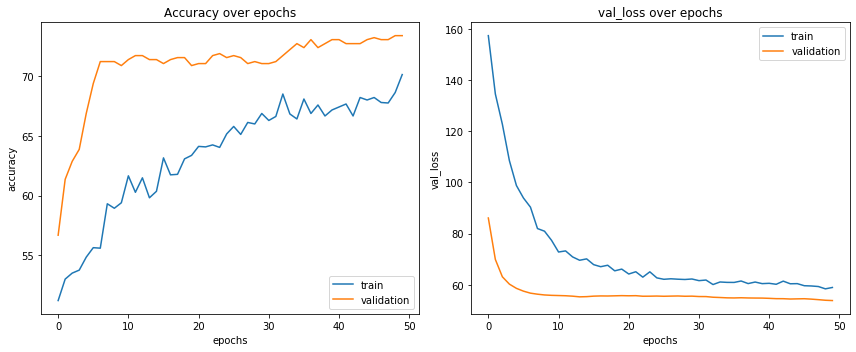

In [46]:
def plot_acc_loss(history):
    def plot_acc(history):
        plt.plot(np.array(history.history['accuracy']) * 100)
        plt.plot(np.array(history.history['val_accuracy']) * 100)
        plt.ylabel('accuracy')
        plt.xlabel('epochs')
        plt.legend(['train', 'validation'])
        plt.title('Accuracy over epochs')
    
    def plot_loss(history):
        plt.plot(np.array(history.history['loss']) * 100)
        plt.plot(np.array(history.history['val_loss']) * 100)
        plt.ylabel('val_loss')
        plt.xlabel('epochs')
        plt.legend(['train', 'validation'])
        plt.title('val_loss over epochs')
        
    plt.subplots(1,2,figsize=(12,5))
    plt.subplot(1, 2, 1)
    plot_acc(history)

    plt.subplot(1, 2, 2)
    plot_loss(history)
    plt.tight_layout()
    plt.show()
    
plot_acc_loss(history)

In [47]:
def performance_nn(classifier,X_test):
    loss, acc = classifier.evaluate(X_test, Y_test)
    print("Test accuracy = ", acc)
    yhat = classifier.predict(X_test)
    yhat = (yhat > 0.5).astype(int)
    print (classification_report(Y_test, yhat))
    return confusion_matrix(Y_test,yhat)

performance_nn(classifier,X_test_pc23)

748/748 [==============================] - 0s 150us/step
Test accuracy =  0.7473261952400208
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       377
           1       0.70      0.85      0.77       371

    accuracy                           0.75       748
   macro avg       0.76      0.75      0.74       748
weighted avg       0.76      0.75      0.74       748



array([[243, 134],
       [ 55, 316]])

In [48]:
""""

Telecom Churn Classification Test Accuracy Summary:

Logistics Regression: 74.73%

KNN Classifier: 75.53%

SVM Classifier: 76.07%

Decision Tree: 72.59%

Random Forest Classifier: 75.67%

AdaBoost: 77.14% (*** Best Model ***) 

XGBoost: 76.74%

NaiveBayes Classifier: 74.73%

Artificial Neural network: 74.73%

"""

'"\n\nTelecom Churn Classification Test Accuracy Summary:\n\nLogistics Regression: 75.53%\n\nKNN Classifier: 73.4%\n\nSVM Classifier: 75.67%\n\nDecision Tree: 75.8%\n\nRandom Forest Classifier: 74.47%\n\nAdaBoost: 77.14% (Best Model)\n\nXGBoost: 77.01%\n\nNaiveBayes Classifier: 75.4%\n\nArtificial Neural network: 75.53%\n\n'

In [55]:
#Add Learning curve

from sklearn.model_selection import learning_curve
from sklearn.metrics import explained_variance_score, make_scorer
from sklearn.model_selection import KFold

def plot_curve():
    
    # instantiate
    ada=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=400, learning_rate=0.1 )

    # fit
    ada.fit(X_train,Y_train)
    
    
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    cv = KFold(len(X_train), shuffle=True)
    
    train_sizes, train_scores, test_scores = learning_curve(ada, X_train, Y_train, n_jobs=-1, cv=cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title("AdaBoostClassifier")
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="lower right")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()

No handles with labels found to put in legend.


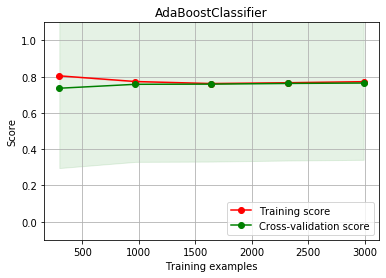

In [56]:
%matplotlib inline
plot_curve()